In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import time
import json
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap

shap.initjs()

In [2]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [3]:
import seaborn as sns

In [4]:
# import glob
# files = glob.glob('./Data/submissions/pennystocks/*.pickle')
# df = pd.concat([pd.read_pickle(fp) for fp in files], ignore_index=True)
# df.to_pickle('./Data/pennystocks_submissions.pickle')

In [5]:
# Load sentiment analysis package, Vader
vader = SentimentIntensityAnalyzer()

***

#### Read and select relevant columns for submissions and comments files for /r/wallstreetbets

In [6]:
wsb_submissions = pd.read_pickle('./Data/wallstreetbets_submissions.pickle')
# Identify relevant submissions columns
submissions_cols = ['title', 'author', 'created_utc', 'selftext', 'id', 'subreddit', 'subreddit_subscribers', 'score']
wsb_submissions_clean = wsb_submissions[submissions_cols]

wsb_comments = pd.read_pickle('./Data/wallstreetbets_comments.pickle')
comments_cols = ['created_utc', 'link_id', 'body', 'score', 'subreddit', 'is_submitter']
wsb_comments_clean = wsb_comments[comments_cols]

# create'id' column in wsb_comments_clean to match post id in 'wsb_submissions_clean' and drop 'link_id' column.
wsb_comments_clean['id'] = wsb_comments_clean['link_id'].apply(lambda x: str(x)[-6:])
wsb_comments_clean = wsb_comments_clean.drop(columns='link_id')

# Add a "timestamp" column with YYYY-MM-DD + time format:
wsb_submissions_clean["timestamp"] = wsb_submissions_clean.created_utc.apply(lambda x: pd.Timestamp(10 ** 9 * x, tz="US/Eastern"))
wsb_comments_clean["timestamp"] = wsb_comments_clean.created_utc.apply(lambda x: pd.Timestamp(10 ** 9 * x, tz="US/Eastern"))

# Add a "date" column with YYYY-MM-DD format:
wsb_submissions_clean["date"] = wsb_submissions_clean.created_utc.apply(lambda x: datetime.utcfromtimestamp(int(x) - 3 * 60 * 60).strftime('%Y-%m-%d'))
wsb_comments_clean["date"] = wsb_comments_clean.created_utc.apply(lambda x: datetime.utcfromtimestamp(int(x) - 3 * 60 * 60).strftime('%Y-%m-%d'))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
wsb_submissions_clean.head()

title         author  created_utc  \
0                              Wall Street Land  Bipedal-Moose   1565880587   
1                     Never go full Anal Farmer        haupt91   1565890620   
2                              Spy back up .58%     f0xl-lound   1565870531   
3  When we see those Chinese Tariffs rolling in    Ganghis_Can   1565889254   
4                                Buy Greenland?   MU_Bagholder   1565918134   

                                            selftext      id       subreddit  \
0                                                     cqqu8q  wallstreetbets   
1                                                     cqt4jl  wallstreetbets   
2  That means the recession is over! Phew, what a...  cqovga  wallstreetbets   
3                                                     cqstd4  wallstreetbets   
4  Do you really think mango was trying to buy an...  cqz76f  wallstreetbets   

   subreddit_subscribers  score                 timestamp        date  
0                 624144  13557 2019-08-15 10:49:47-04:00  2019-08-15  
1                 624305   7389 2019-08-15 13:37:00-04:00  2019-08-15  
2                 623981   1451 2019-08-15 08:02:11-04:00  2019-08-15  
3                 624275   1267 2019-08-15 13:14:14-04:00  2019-08-15  
4                 625091    995 2019-08-15 21:15:34-04:00  2019-08-15

In [8]:
wsb_comments_clean.head()

created_utc                              body  score       subreddit  \
0   1573881670  Couldn't breathe, couldn't speak      1  wallstreetbets   
1   1566915272                 I read socks lmao      1  wallstreetbets   
2   1566080830           What’s the movie/ show?      1  wallstreetbets   
3   1566011343                      Aristocrats!      1  wallstreetbets   
4   1566000937     Whatcha gonna name it sailor?      1  wallstreetbets   

   is_submitter      id                 timestamp        date  
0         False  cqqu8q 2019-11-16 00:21:10-05:00  2019-11-16  
1         False  cqqu8q 2019-08-27 10:14:32-04:00  2019-08-27  
2         False  cqqu8q 2019-08-17 18:27:10-04:00  2019-08-17  
3         False  cqqu8q 2019-08-16 23:09:03-04:00  2019-08-17  
4         False  cqqu8q 2019-08-16 20:15:37-04:00  2019-08-16

#### Plot of number of reddit users subscribed to /r/wallstreetbets over the period 08-15-2019 to 08-15-2020.

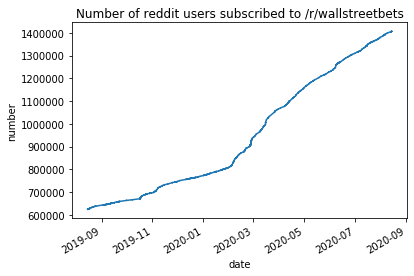

In [9]:
plt.figure()
plt.plot([x.to_pydatetime() for x in wsb_submissions_clean['timestamp']], wsb_submissions_clean['subreddit_subscribers'])
plt.gcf().autofmt_xdate()
plt.title('Number of reddit users subscribed to /r/wallstreetbets')
plt.xlabel('date')
plt.ylabel('number')
plt.show()

#### Sentiment analysis on both submissions and comments

In [10]:
# Applying the sentiment analysis to 'title' column of submissions df
wsb_title_scores = wsb_submissions_clean['title'].astype(str).apply(vader.polarity_scores).tolist()
wsb_title_scores = pd.DataFrame(wsb_title_scores)
wsb_title_scores = wsb_title_scores.add_prefix('title_')

# Merging our headline dataframe with our title sentiment scores dataframe
wsb_submissions_clean = wsb_submissions_clean.join(wsb_title_scores, rsuffix='_right')

In [11]:
# Applying sentiment analysis to 'body' column of submissions df
wsb_body_scores = wsb_submissions_clean['selftext'].astype(str).apply(vader.polarity_scores).tolist()
wsb_body_scores = pd.DataFrame(wsb_body_scores)
wsb_body_scores = wsb_body_scores.add_prefix('body_')

# Merging our headline dataframe with our body sentiment scores dataframe
wsb_submissions_clean = wsb_submissions_clean.join(wsb_body_scores, rsuffix='_right')

In [12]:
# Applying the sentiment analysis to 'body' column of comments df
wsb_comments_scores = wsb_comments_clean['body'].astype(str).apply(vader.polarity_scores).tolist()
wsb_comments_scores = pd.DataFrame(wsb_comments_scores)
wsb_comments_scores = wsb_comments_scores.add_prefix('comments_')

# Merging our headline dataframe with our comments sentiment scores dataframe
wsb_comments_clean = wsb_comments_clean.join(wsb_comments_scores, rsuffix='_right')

In [13]:
wsb_submissions_clean.head()

title         author  created_utc  \
0                              Wall Street Land  Bipedal-Moose   1565880587   
1                     Never go full Anal Farmer        haupt91   1565890620   
2                              Spy back up .58%     f0xl-lound   1565870531   
3  When we see those Chinese Tariffs rolling in    Ganghis_Can   1565889254   
4                                Buy Greenland?   MU_Bagholder   1565918134   

                                            selftext      id       subreddit  \
0                                                     cqqu8q  wallstreetbets   
1                                                     cqt4jl  wallstreetbets   
2  That means the recession is over! Phew, what a...  cqovga  wallstreetbets   
3                                                     cqstd4  wallstreetbets   
4  Do you really think mango was trying to buy an...  cqz76f  wallstreetbets   

   subreddit_subscribers  score                 timestamp        date  \
0                 624144  13557 2019-08-15 10:49:47-04:00  2019-08-15   
1                 624305   7389 2019-08-15 13:37:00-04:00  2019-08-15   
2                 623981   1451 2019-08-15 08:02:11-04:00  2019-08-15   
3                 624275   1267 2019-08-15 13:14:14-04:00  2019-08-15   
4                 625091    995 2019-08-15 21:15:34-04:00  2019-08-15   

   title_neg  title_neu  title_pos  title_compound  body_neg  body_neu  \
0        0.0        1.0        0.0             0.0     0.000     0.000   
1        0.0        1.0        0.0             0.0     0.000     0.000   
2        0.0        1.0        0.0             0.0     0.133     0.533   
3        0.0        1.0        0.0             0.0     0.000     0.000   
4        0.0        1.0        0.0             0.0     0.088     0.866   

   body_pos  body_compound  
0     0.000         0.0000  
1     0.000         0.0000  
2     0.333         0.8748  
3     0.000         0.0000  
4     0.046        -0.7236

In [14]:
wsb_comments_clean.head()

created_utc                              body  score       subreddit  \
0   1573881670  Couldn't breathe, couldn't speak      1  wallstreetbets   
1   1566915272                 I read socks lmao      1  wallstreetbets   
2   1566080830           What’s the movie/ show?      1  wallstreetbets   
3   1566011343                      Aristocrats!      1  wallstreetbets   
4   1566000937     Whatcha gonna name it sailor?      1  wallstreetbets   

   is_submitter      id                 timestamp        date  comments_neg  \
0         False  cqqu8q 2019-11-16 00:21:10-05:00  2019-11-16           0.0   
1         False  cqqu8q 2019-08-27 10:14:32-04:00  2019-08-27           0.0   
2         False  cqqu8q 2019-08-17 18:27:10-04:00  2019-08-17           0.0   
3         False  cqqu8q 2019-08-16 23:09:03-04:00  2019-08-17           0.0   
4         False  cqqu8q 2019-08-16 20:15:37-04:00  2019-08-16           0.0   

   comments_neu  comments_pos  comments_compound  
0         1.000         0.000             0.0000  
1         0.339         0.661             0.5994  
2         1.000         0.000             0.0000  
3         1.000         0.000             0.0000  
4         1.000         0.000             0.0000

***

### Exploring specific companies

In [15]:
# 30 most popular stocks on Robinhood plus Shapchat, Tesla, Apple, AMD and Netflix.
ticker_dict = {
    "TSLA": ["tsla", "tesla", "elon", "musk", "electric vehicle", "model 3", "model x", "model y", "model s"],
    "MSFT": ["msft", "microsoft", "bill gates", "gates", "windows"],
    "BABA": ["ali baba", "alibaba", "jack ma"],
    "GOOGL": ["google", "googl", "search engine"],
    "NFLX": ["nflx", "netflix", "streaming"],
    "AMZN": ["amzn", "amazon", "bezos"],
    "FB": ["fb", "facebook", "zuckerberg"],
    "UBER": ["uber", "ride sharing"],
    "NVDA": ["nvda", "nvidia"],
    "AMD": ["amd", "lisa su"],
    "SNAP": ["snap", "snapchat"],
    "APHA": ["apha", "aphria"], #cannibis
    "CPRX": ["cprx", "catalyst pharmaceuticals"], #pharma
    "DIS": ["dis", "disney", "walt disney"], 
    "DKNG": ["dkng", "draftkings"], 
    "ET": ["et", "energy transfer"],
    "GE": ["ge", "general electric"], 
    "GM": ["gm", "general motors"],
    "JNJ": ["jnj", "j&j", "Johnson & Johnson"], 
    "JPM": ["jpm", "jpmorgan", "jpmorgan chase"], 
    "KO": ["ko", "coca-cola", "coca cola"], 
    "MRNA": ["mrna", "moderna"], #pharma
    "NKE": ["nke", "nike"],
    "NRZ": ["new residential investment", "nrz"], 
    "NTDOY": ["ntdoy", "nintendo"], #games
    "PENN": ["penn", "penn national gaming"], #games
    "PLUG": ["plug", "plug power"], #hydrogen
    "PTON": ["pton", "peloton"], 
    "PYPL":["paypal", "pypl"], 
    "SNE": ["sne", "sony"], 
    "TXMD": ["txmd", "therapeutic md"], #pharma - womens
    "V": ["v", "visa", "visa inc"], 
    "WMT": ["wmt", "walmart"], 
    "ZNGA": ["znga", "zynga"] #games
}

***

In [16]:
def filter_by_keyword(df, keywords):
    return df[
        df.title.str.lower().str.contains("|".join(keywords))
        | df.selftext.str.lower().str.contains("|".join(keywords))
    ]

In [17]:
popularity = pd.read_csv(f"data/robintrack-popularity-history/tmp/popularity_export/TSLA.csv", index_col=0)
popularity.index = popularity.index.map(pd.Timestamp)
popularity["date"] = popularity.index.map(lambda x: x.date())
popularity = popularity.drop_duplicates(subset=["date"], keep="last")
popularity["log_change"] = np.log(popularity.users_holding).diff()
popularity

users_holding        date  log_change
timestamp                                                 
2018-05-02 06:38:31          81038  2018-05-02         NaN
2018-05-03 23:42:40          83646  2018-05-03    0.031675
2018-05-04 23:42:42          83240  2018-05-04   -0.004866
2018-05-05 23:42:41          83237  2018-05-05   -0.000036
2018-05-06 23:42:42          83237  2018-05-06    0.000000
...                            ...         ...         ...
2020-08-09 23:45:45         540766  2020-08-09    0.000000
2020-08-10 23:45:32         542123  2020-08-10    0.002506
2020-08-11 23:45:44         543948  2020-08-11    0.003361
2020-08-12 23:46:03         563245  2020-08-12    0.034861
2020-08-13 22:54:47         563621  2020-08-13    0.000667

[818 rows x 3 columns]

In [18]:
# Change this to vary time window

In [23]:
def get_bin_label(ts):
    ## every week
    # ts.week()
    ## every 3 days
    # (ts - pd.Timestamp("20000101")).days // 3
    # every day
    #ts.date
    return ts.week

In [24]:
def get_popularity(stock_ticker, fdir="data/robintrack-popularity-history/tmp/popularity_export"):
    popularity = pd.read_csv(f"{fdir}/{stock_ticker}.csv", index_col=0)
    popularity.index = popularity.index.map(pd.Timestamp)
    # every day
    popularity["bin_label"] = popularity.index.map(get_bin_label)
    popularity = popularity.groupby("bin_label").mean()
    popularity["log_change"] = np.log(popularity.users_holding).diff()
    return popularity

In [25]:
def make_X_Y(popularity, submissions, comments):
    Y = popularity.users_holding
    X = pd.DataFrame(index=popularity.index) 

    submissions["bin_label"] = submissions.timestamp.apply(get_bin_label)
    comments["bin_label"] = comments.timestamp.apply(get_bin_label)

    X["num_posts"] = submissions.groupby("bin_label").title.count()
    X.loc[X.num_posts.isna(), "num_posts"] = 0
    
    X["num_comments"] = comments.groupby("bin_label").body.count()
    X.loc[X.num_comments.isna(), "num_comments"] = 0

    X["mean_post_title_sentiment"] = submissions.groupby("bin_label").title_compound.mean()
    X.loc[X.mean_post_title_sentiment.isna(), "mean_post_title_sentiment"] = 0
    
    X["mean_post_body_sentiment"] = submissions.groupby("bin_label").body_compound.mean()
    X.loc[X.mean_post_body_sentiment.isna(), "mean_post_body_sentiment"] = 0
    
    X["mean_comments_sentiment"] = comments.groupby(["bin_label"]).comments_compound.mean()
    X.loc[X.mean_comments_sentiment.isna(), "mean_comments_sentiment"] = 0

    X["num_up_votes"] = submissions.groupby("bin_label").score.sum()
    X.loc[X.num_up_votes.isna(), "num_up_votes"] = 0

    X["vote_weighted_post_title_sentiment"] = submissions.groupby("bin_label").apply(lambda x: np.sum(x.score * x.title_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_post_title_sentiment.isna(), "vote_weighted_post_title_sentiment"] = 0
    
    X["vote_weighted_post_body_sentiment"] = submissions.groupby(["bin_label"]).apply(lambda x: np.sum(x.score * x.body_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_post_body_sentiment.isna(), "vote_weighted_post_body_sentiment"] = 0
    
    X["vote_weighted_comments_sentiment"] = comments.groupby(["bin_label"]).apply(lambda x: np.sum(x.score * x.comments_compound) / np.sum(x.score))
    X.loc[X.vote_weighted_comments_sentiment.isna(), "vote_weighted_comments_sentiment"] = 0
    
    return X, Y

In [26]:
X = []
Y = []
for ticker, keywords in ticker_dict.items():
    pop = get_popularity(ticker)
    sub = filter_by_keyword(wsb_submissions_clean, keywords)
    com = wsb_comments_clean[wsb_comments_clean.id.isin(sub.id)]
    if len(sub) == 0 or len(com) == 0:
        continue
    X_some, Y_some = make_X_Y(pop, sub, com)
    X.append(X_some)
    Y.append(Y_some)
X = pd.concat(X, axis=0).astype(float)
Y = pd.concat(Y, axis=0).astype(float)
mask = np.any(X.isna(), axis=1).values
mask |= Y.isna().values
X = X.loc[~mask]
Y = Y.loc[~mask]
X.shape, Y.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
invalid value encountered in double_scalars


((1624, 9), (1624,))

In [27]:
# This df also includes the days (from RH data) for which we do not have the reddit data. 
X.head()

num_posts  num_comments  mean_post_title_sentiment  \
bin_label                                                       
1               11.0         199.0                   0.036400   
2               14.0         162.0                   0.035379   
3               22.0         242.0                   0.079109   
4               19.0         166.0                  -0.015695   
5               26.0         297.0                   0.016108   

           mean_post_body_sentiment  mean_comments_sentiment  num_up_votes  \
bin_label                                                                    
1                          0.140055                 0.064505         735.0   
2                          0.039621                 0.028833          14.0   
3                          0.107614                 0.072390          23.0   
4                          0.212505                 0.096772          19.0   
5                          0.159262                 0.014128         120.0   

           vote_weighted_post_title_sentiment  \
bin_label                                       
1                                    0.049683   
2                                    0.035379   
3                                    0.075670   
4                                   -0.015695   
5                                   -0.017254   

           vote_weighted_post_body_sentiment  vote_weighted_comments_sentiment  
bin_label                                                                       
1                                   0.196067                          0.052477  
2                                   0.039621                          0.046112  
3                                   0.102935                          0.044014  
4                                   0.212505                          0.041079  
5                                   0.254464                         -0.007863

In [28]:
# Filter out days with no posts 

mask = ~np.all(X == 0, axis=1).values
X_nonzero = X[mask]
Y_nonzero = Y[mask]

In [29]:
print(X_nonzero.shape)
print(Y_nonzero.shape)

(1163, 9)
(1163,)


In [30]:
X_nonzero.head()

num_posts  num_comments  mean_post_title_sentiment  \
bin_label                                                       
1               11.0         199.0                   0.036400   
2               14.0         162.0                   0.035379   
3               22.0         242.0                   0.079109   
4               19.0         166.0                  -0.015695   
5               26.0         297.0                   0.016108   

           mean_post_body_sentiment  mean_comments_sentiment  num_up_votes  \
bin_label                                                                    
1                          0.140055                 0.064505         735.0   
2                          0.039621                 0.028833          14.0   
3                          0.107614                 0.072390          23.0   
4                          0.212505                 0.096772          19.0   
5                          0.159262                 0.014128         120.0   

           vote_weighted_post_title_sentiment  \
bin_label                                       
1                                    0.049683   
2                                    0.035379   
3                                    0.075670   
4                                   -0.015695   
5                                   -0.017254   

           vote_weighted_post_body_sentiment  vote_weighted_comments_sentiment  
bin_label                                                                       
1                                   0.196067                          0.052477  
2                                   0.039621                          0.046112  
3                                   0.102935                          0.044014  
4                                   0.212505                          0.041079  
5                                   0.254464                         -0.007863

In [31]:
Y_nonzero

bin_label
1     102654.473054
2      85357.068182
3     101281.929688
4     121612.552511
5     121418.163333
          ...      
18    112892.344262
30    140587.661538
31    125596.277778
35     80995.100946
38     84526.368263
Name: users_holding, Length: 1163, dtype: float64

In [32]:
popularity.size

2454

Text(0.5, 1.0, 'Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

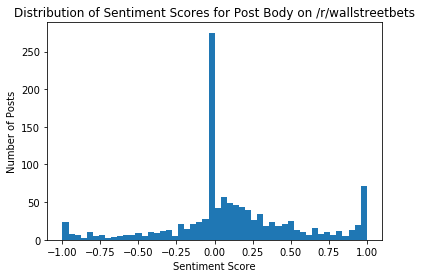

In [33]:
plt.hist(X_nonzero['mean_post_body_sentiment'].values, bins=50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Posts')
plt.title('Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

Text(0.5, 1.0, 'Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

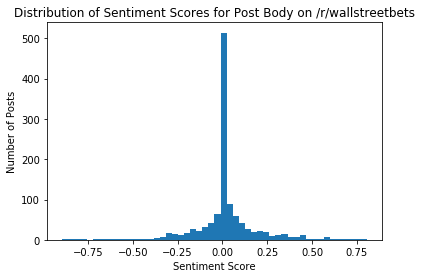

In [34]:
plt.hist(X_nonzero['mean_post_title_sentiment'].values, bins=50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Posts')
plt.title('Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

Text(0.5, 1.0, 'Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

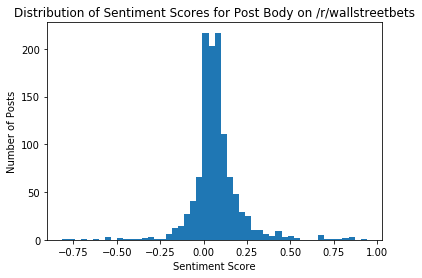

In [35]:
plt.hist(X_nonzero['mean_comments_sentiment'].values, bins=50)
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Posts')
plt.title('Distribution of Sentiment Scores for Post Body on /r/wallstreetbets')

In [36]:
# Filter out entries with sentiment scores >=0.05 or <=0.05

mask = abs(X_nonzero['mean_post_body_sentiment']) >= 0.05
X_nonzero_2 = X_nonzero[mask]
Y_nonzero_2 = Y_nonzero[mask]

In [37]:
X_nonzero.shape

(1163, 9)

In [38]:
X_nonzero_2.shape

(823, 9)

***

# Including all sentiment scores

In [39]:
Xt, Xv, yt, yv = train_test_split(X_nonzero, Y_nonzero, test_size=0.2)

# OLS

In [40]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(Xt) - yt)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [41]:
Xt_summary = shap.kmeans(Xt, 10)

In [42]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(Xt, yt)

print_accuracy(lin_reg.predict)

Root mean squared test error = 86704.20902800708


In [43]:
ex = shap.KernelExplainer(lin_reg.predict, Xt_summary)
shap_values = ex.shap_values(Xt.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, Xt.iloc[0,:])

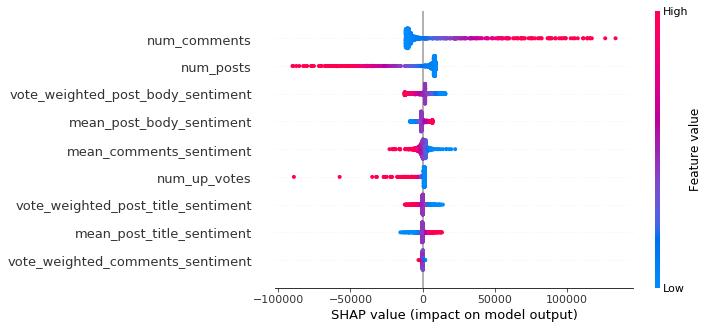

In [44]:
shap_values = ex.shap_values(Xt)
shap.summary_plot(shap_values, Xt)

In [45]:
shap_values.shape, Xv.shape

((930, 9), (233, 9))

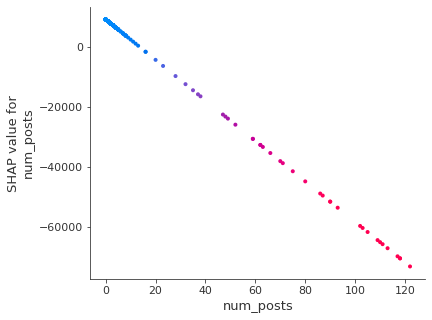

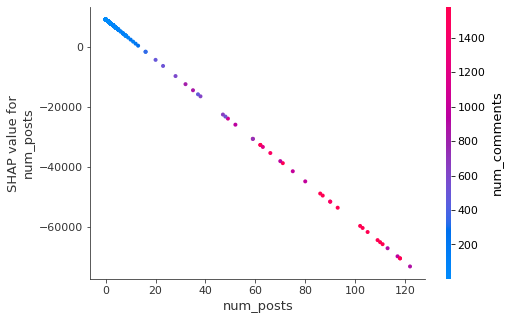

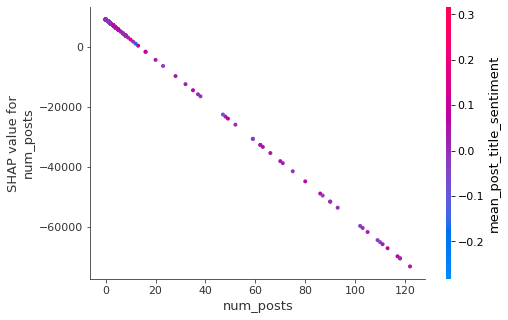

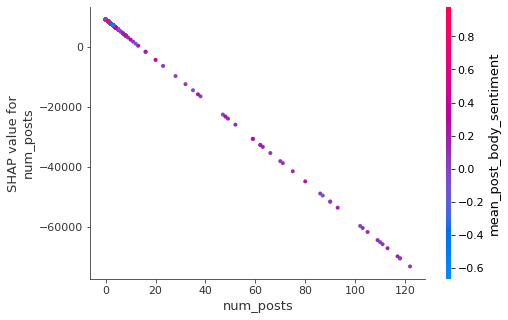

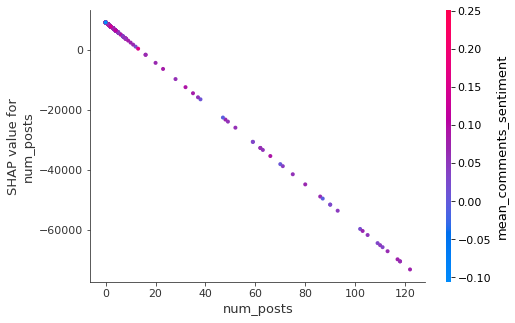

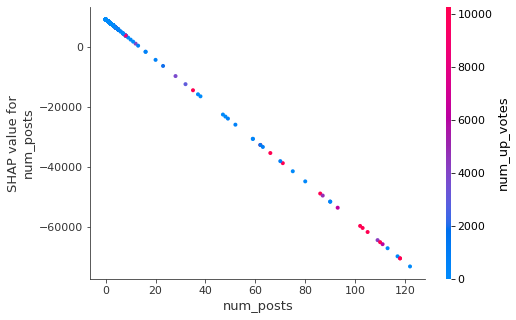

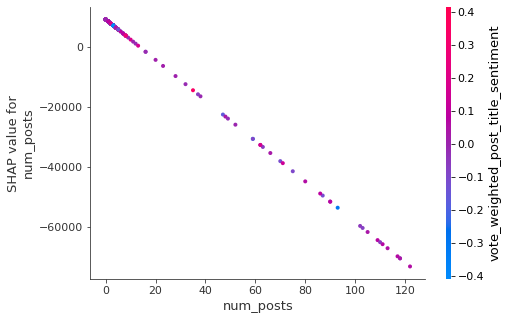

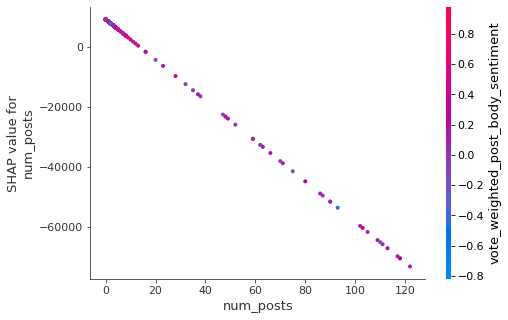

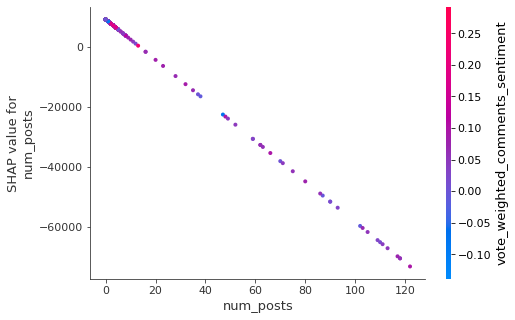

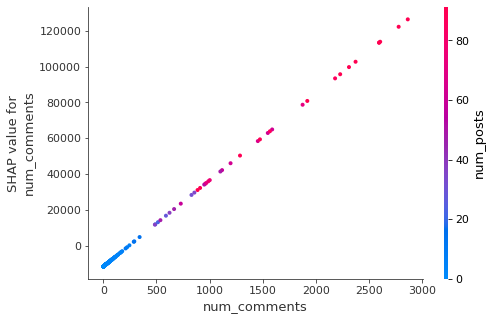

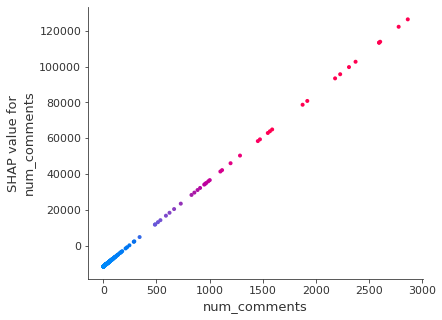

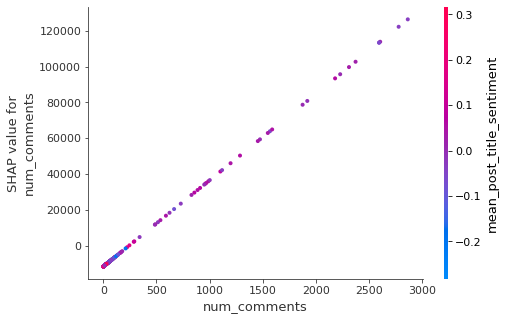

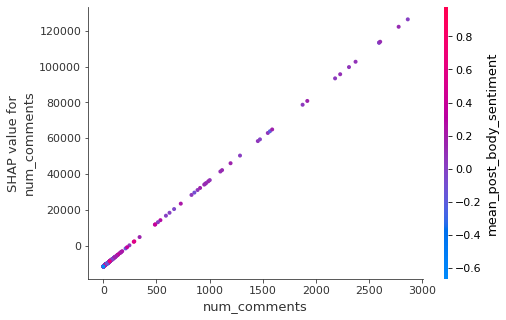

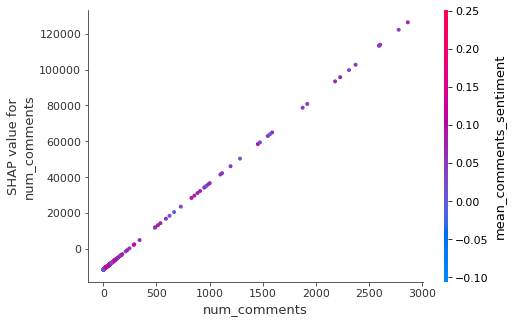

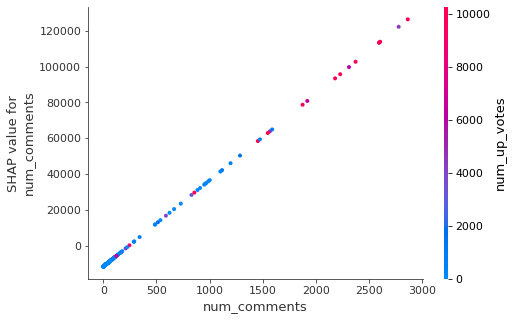

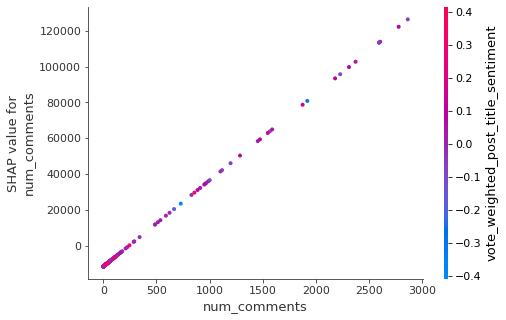

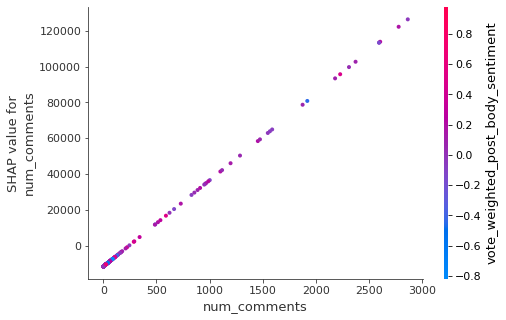

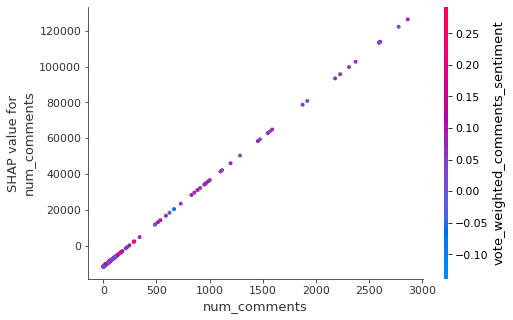

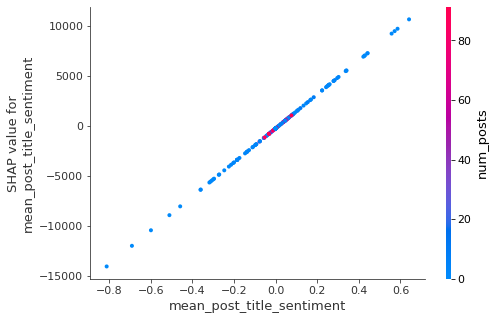

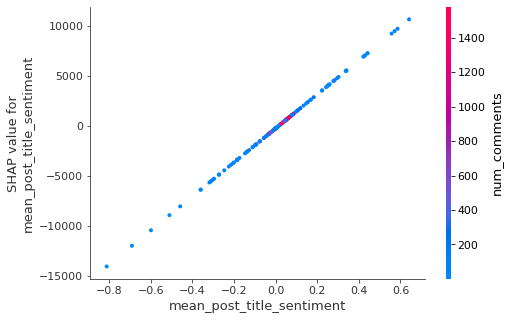

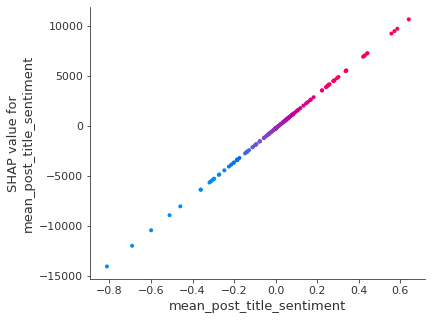

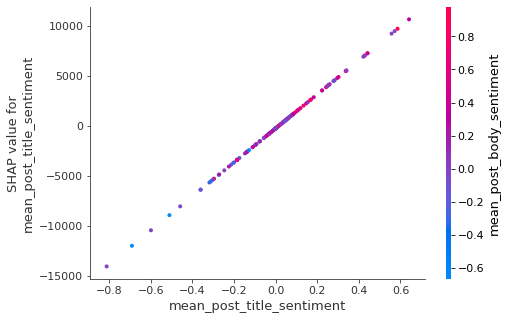

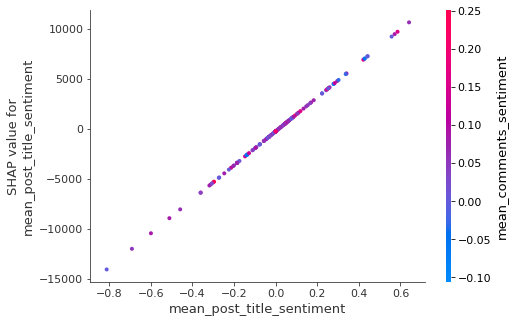

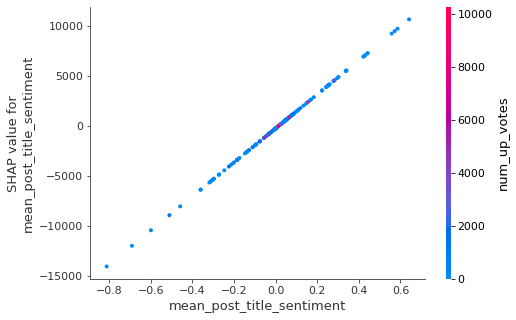

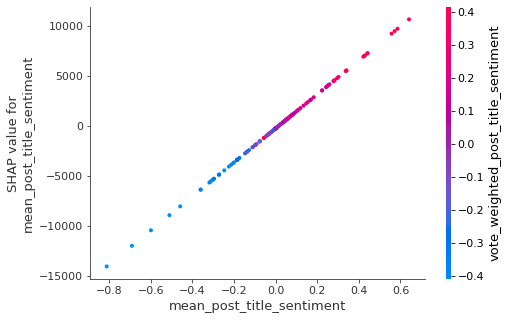

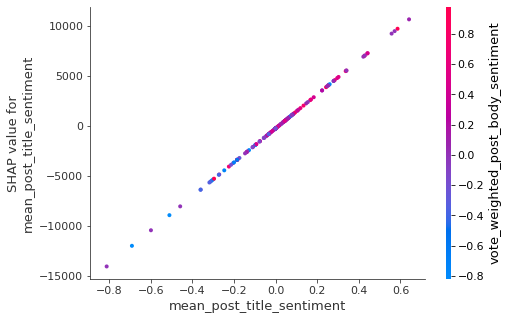

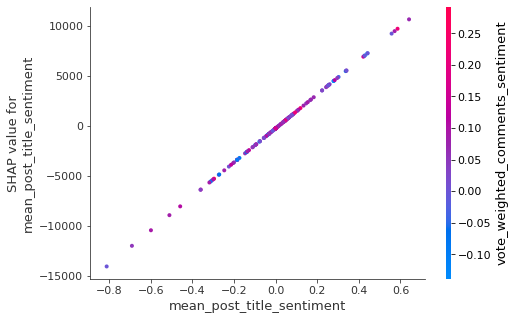

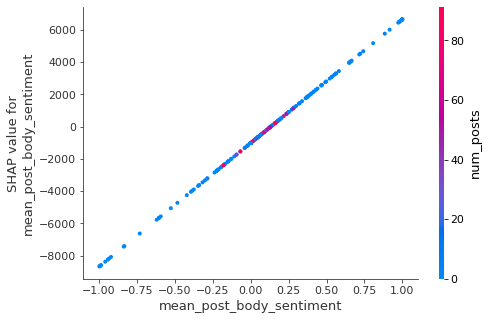

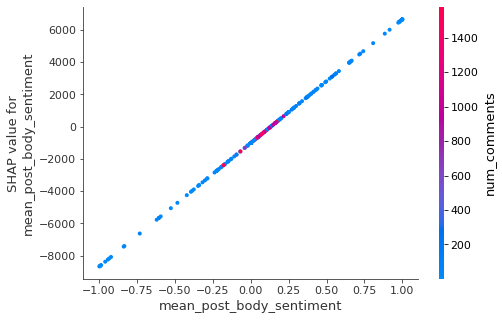

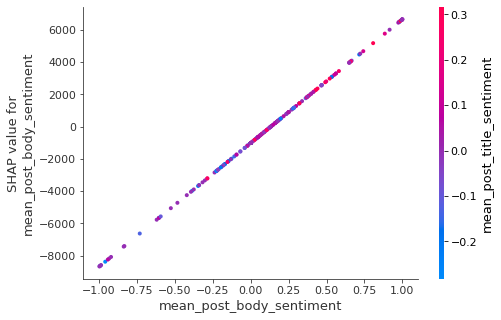

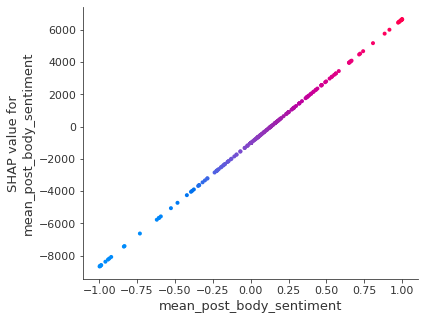

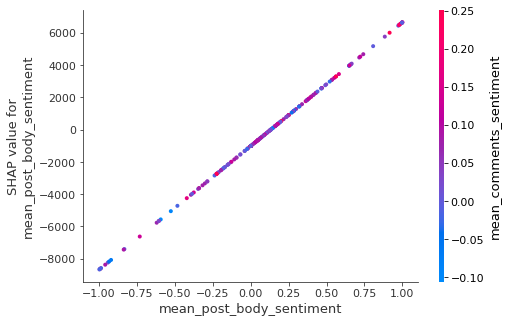

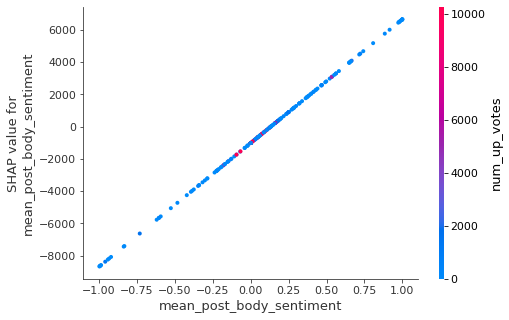

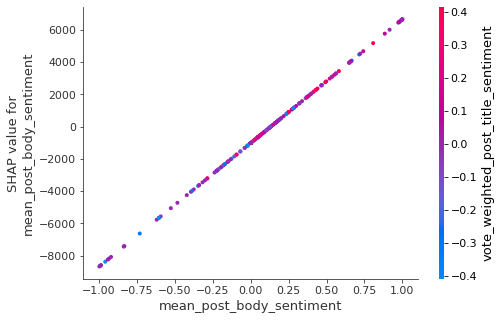

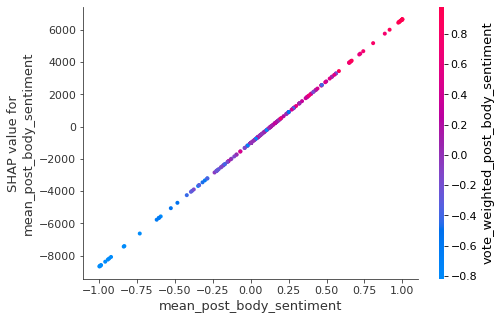

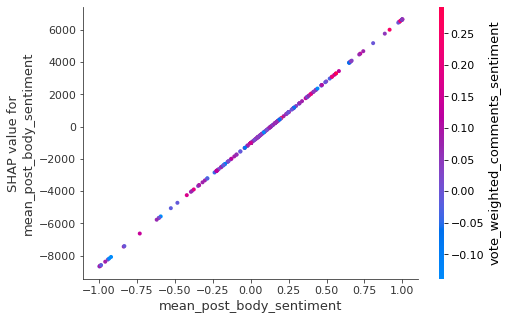

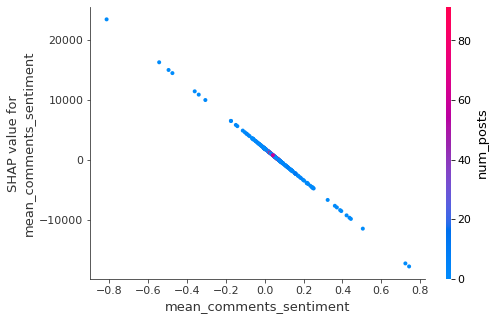

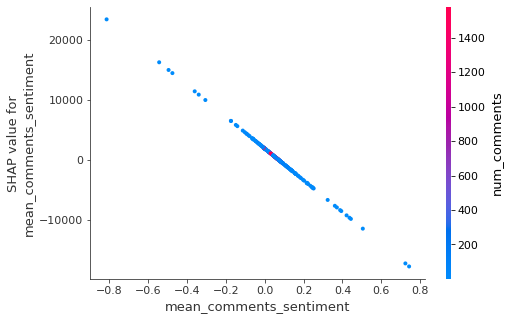

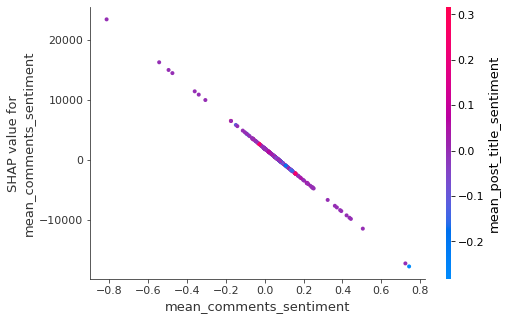

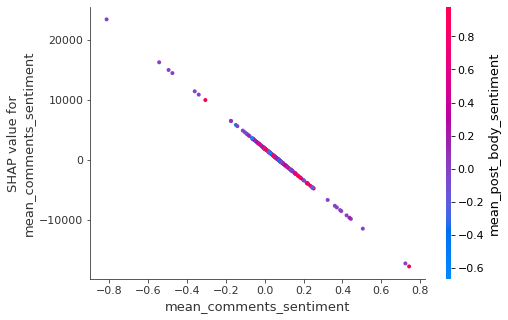

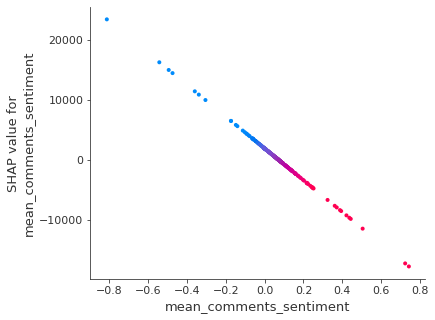

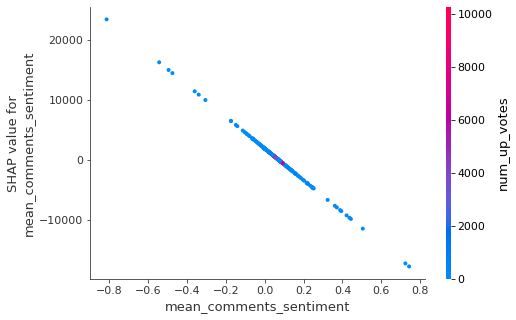

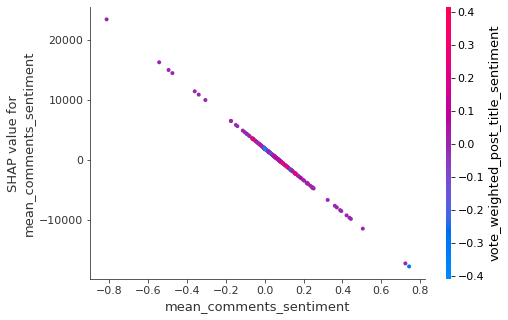

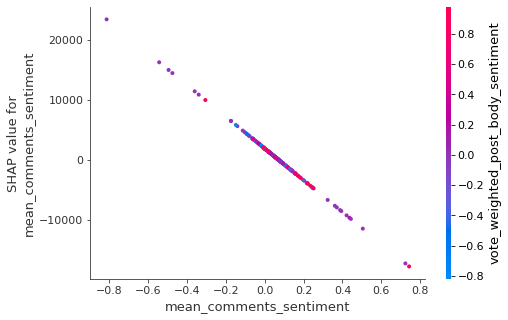

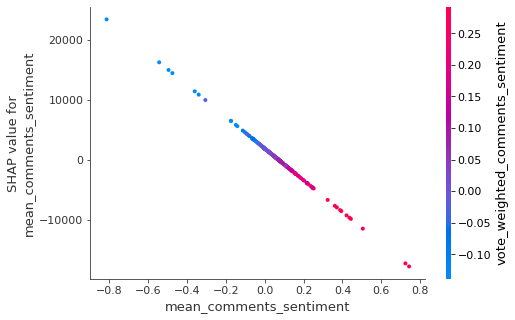

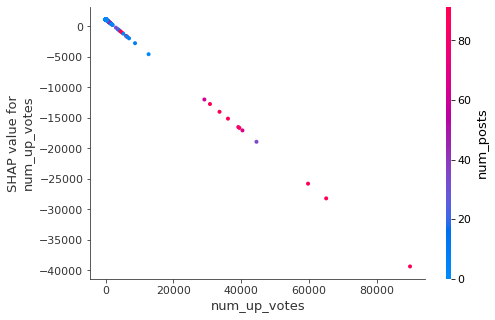

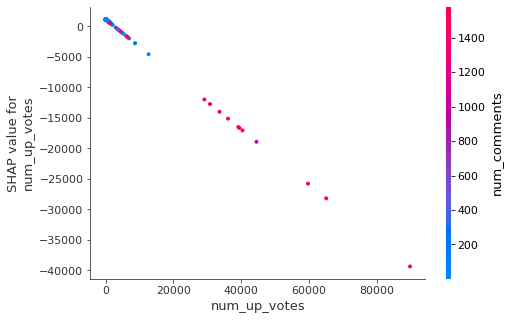

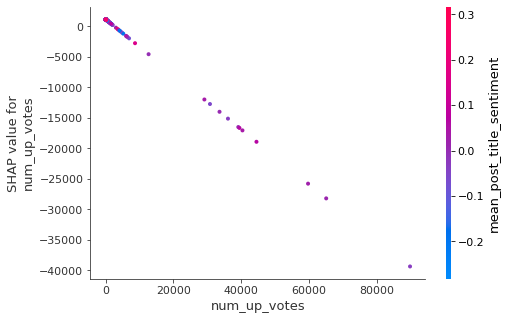

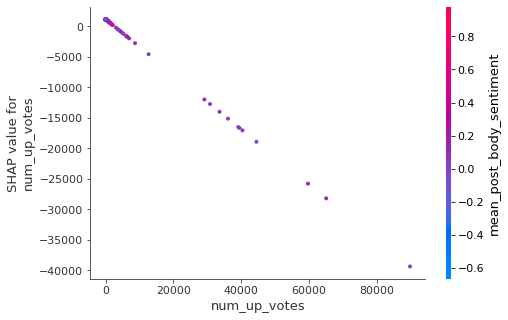

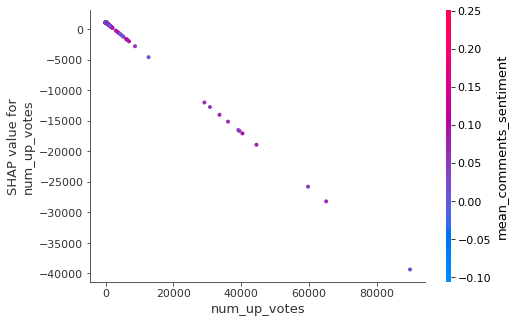

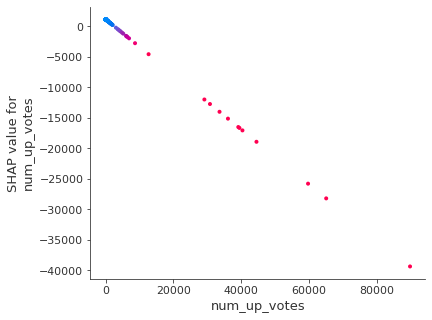

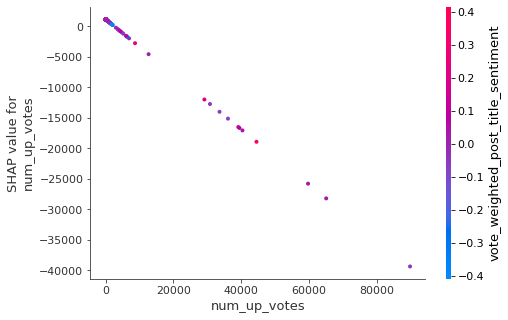

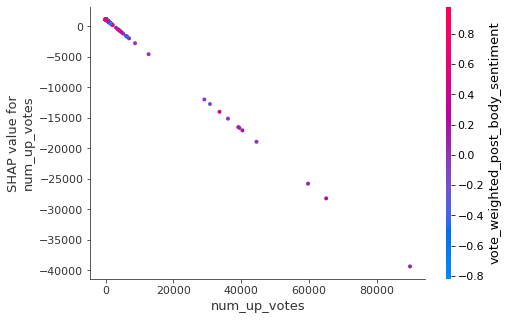

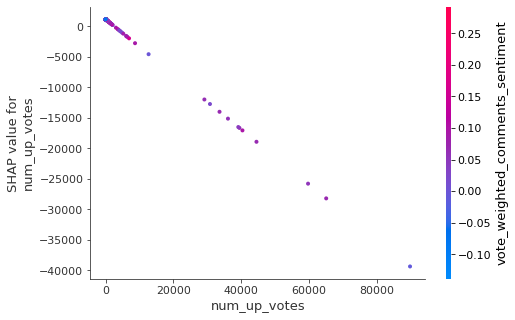

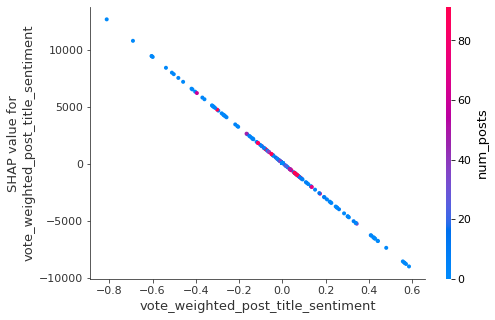

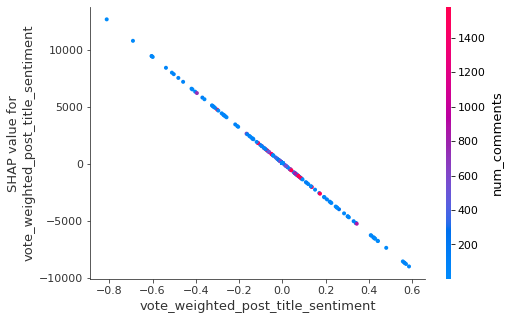

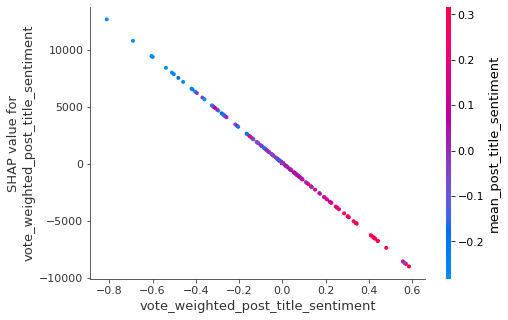

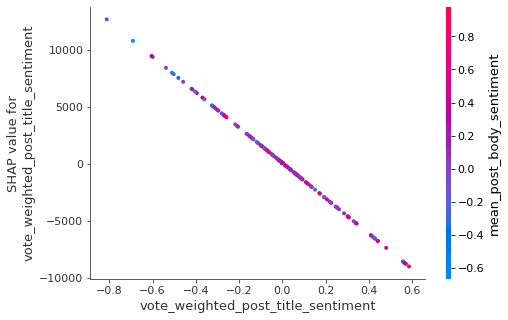

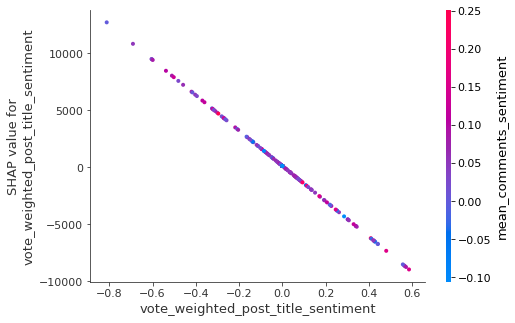

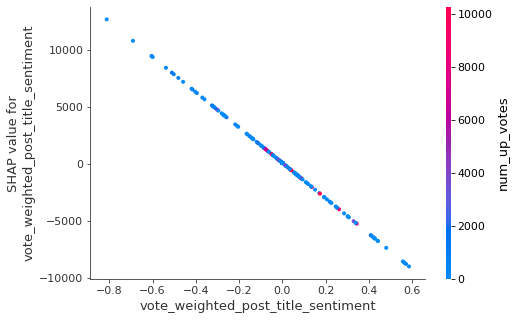

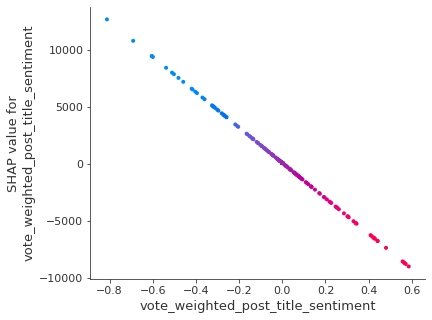

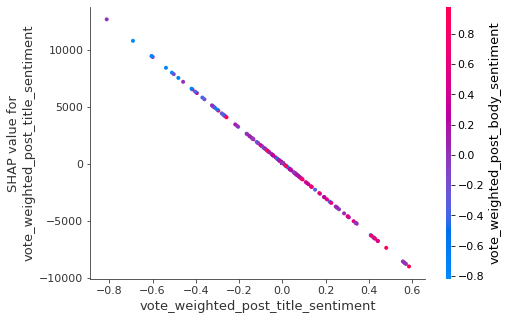

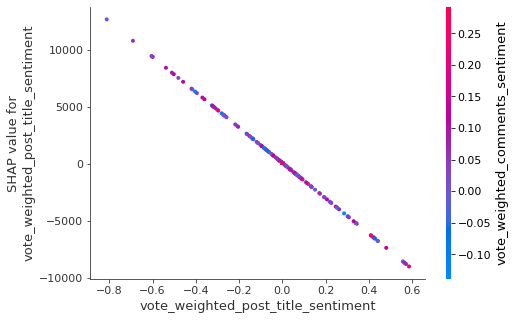

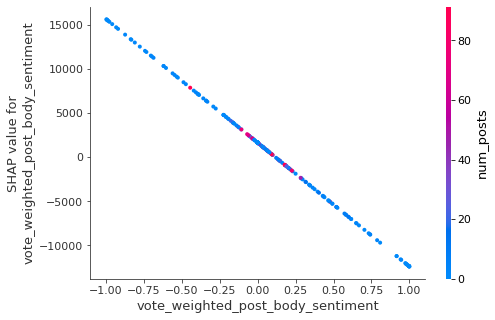

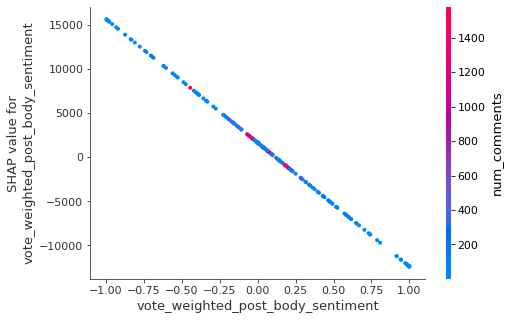

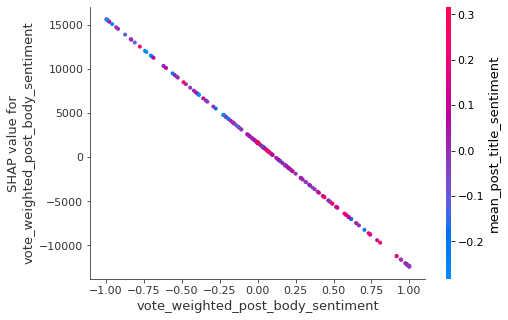

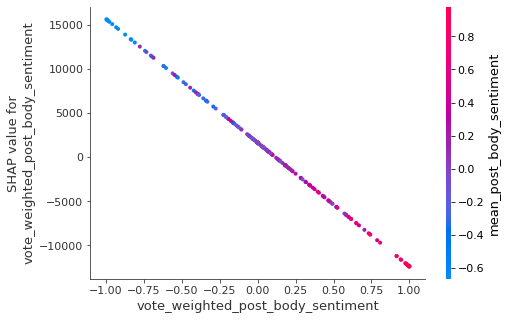

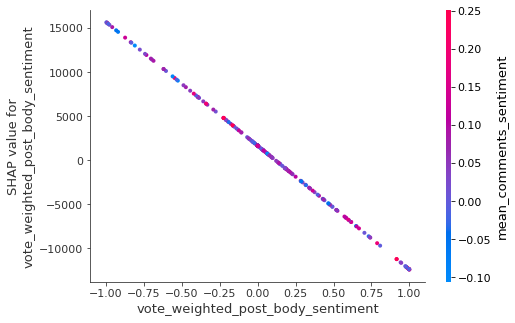

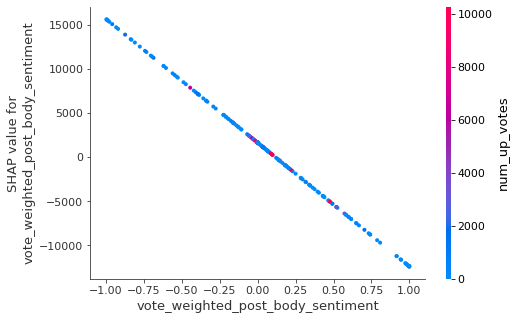

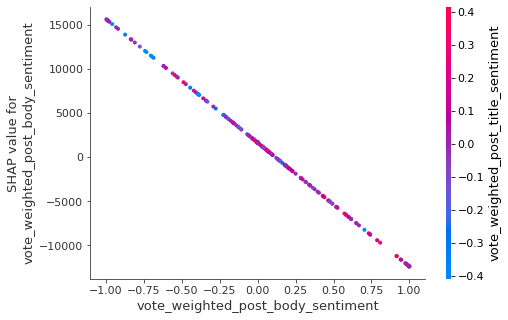

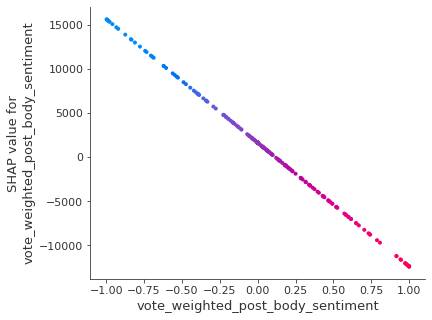

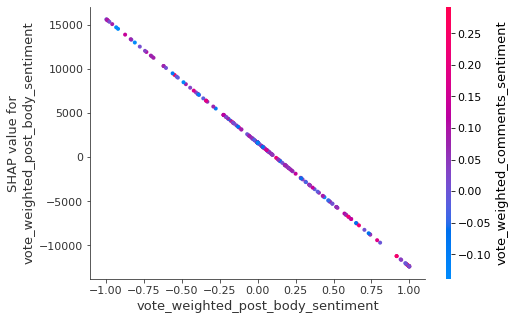

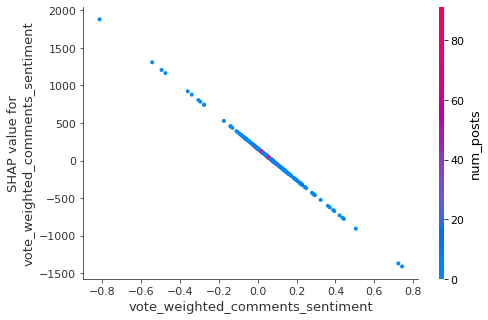

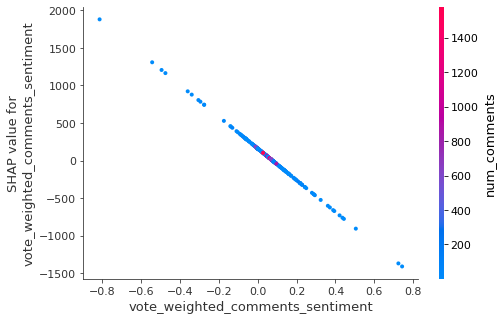

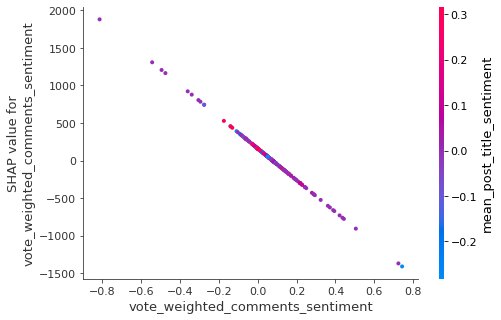

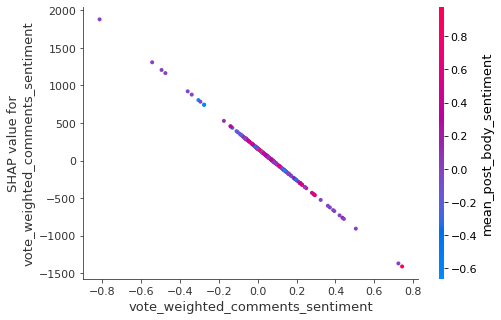

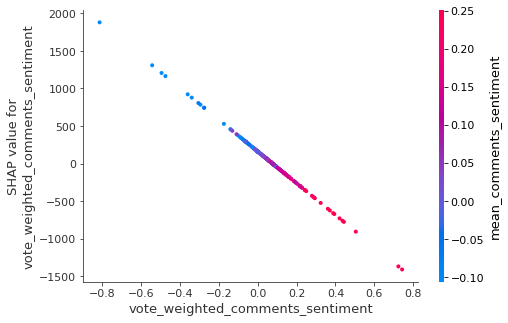

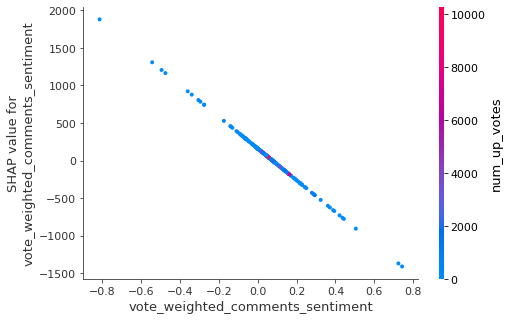

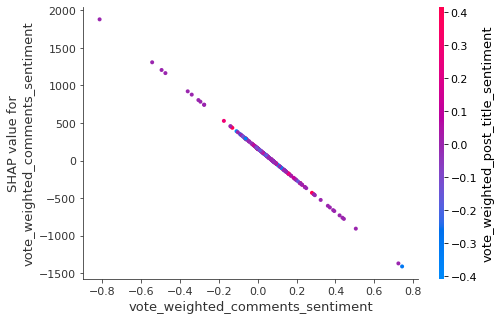

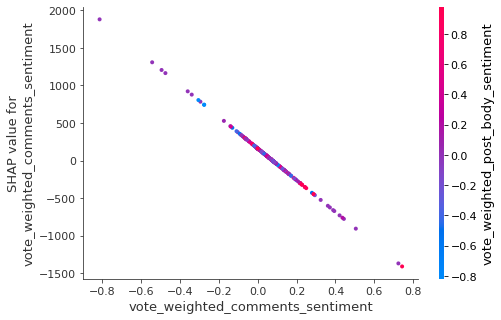

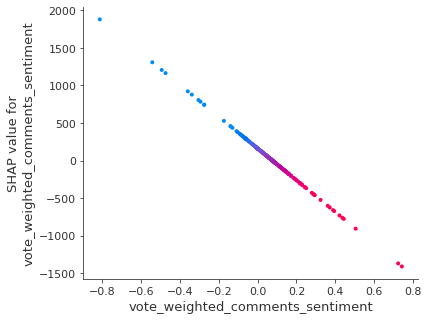

In [46]:
shap_values = ex.shap_values(Xv)
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(x, shap_values, Xv, interaction_index=y)

In [47]:
X_nonzero_c = sm.add_constant(X_nonzero)
model = sm.OLS(Y_nonzero, X_nonzero_c) # fitting OLS
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          users_holding   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.430
Date:                Fri, 09 Oct 2020   Prob (F-statistic):              0.170
Time:                        14:46:55   Log-Likelihood:                -14856.
No. Observations:                1163   AIC:                         2.973e+04
Df Residuals:                    1153   BIC:                         2.978e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

***

# XGBoost and SHAP

In [48]:
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [49]:
params = {
    "eta": .3,
    "max_depth": 10,
    "objective": "reg:squarederror",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 3, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:-3.82157e+06	valid-logloss:-3.86714e+06
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[2]	train-logloss:-3.82157e+06	valid-logloss:-3.86714e+06


In [50]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [51]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

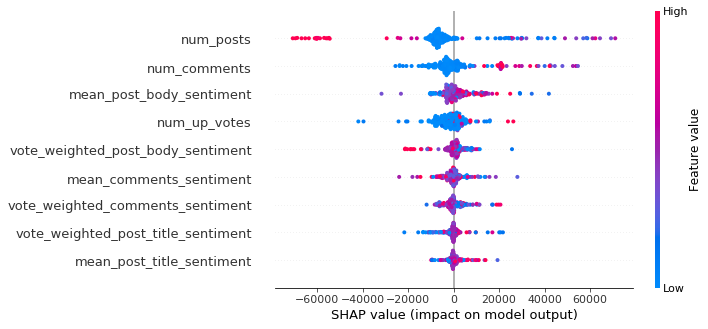

In [52]:
shap.summary_plot(shap_values, Xv)

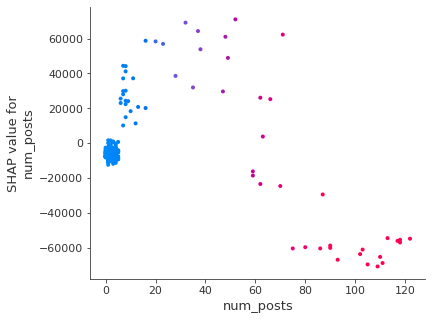

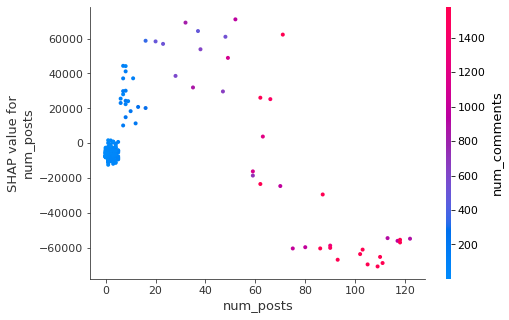

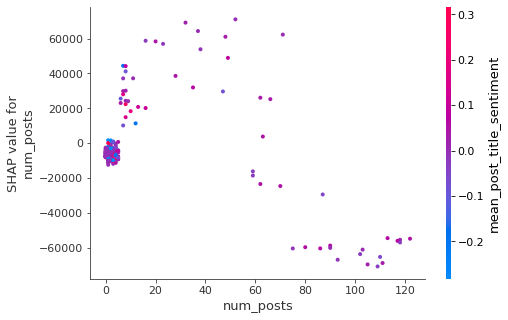

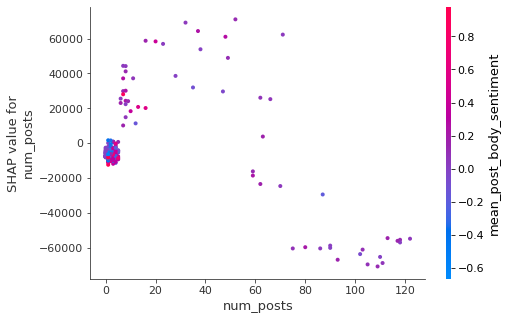

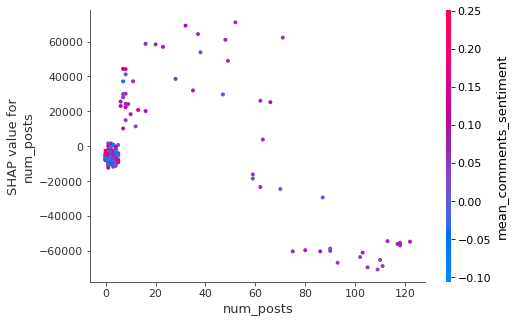

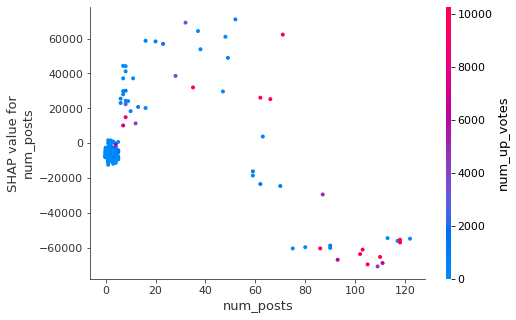

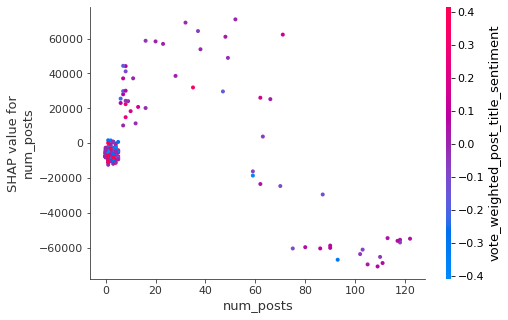

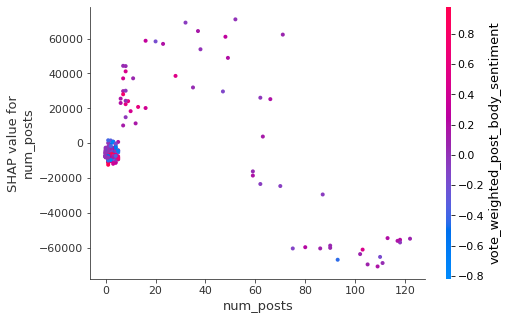

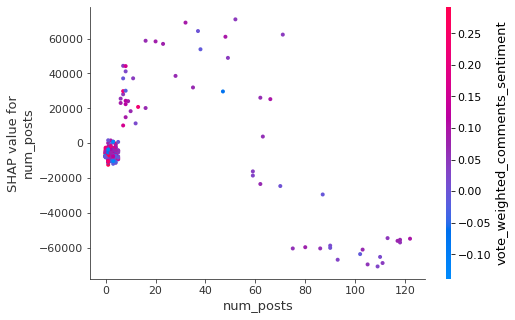

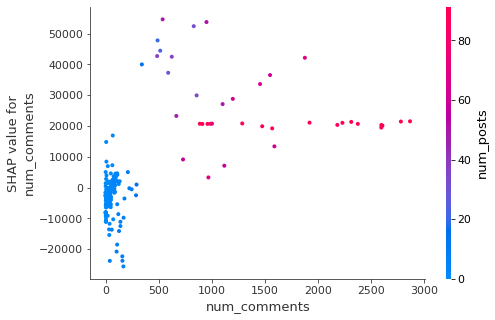

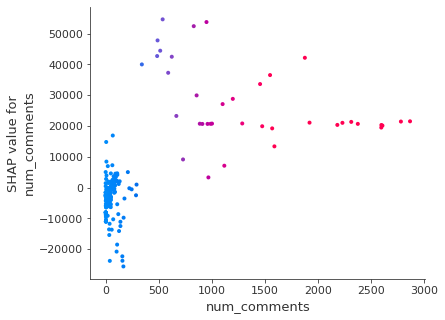

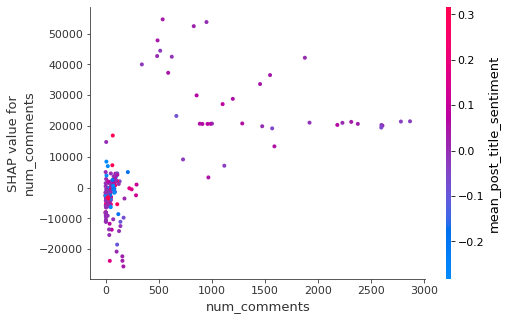

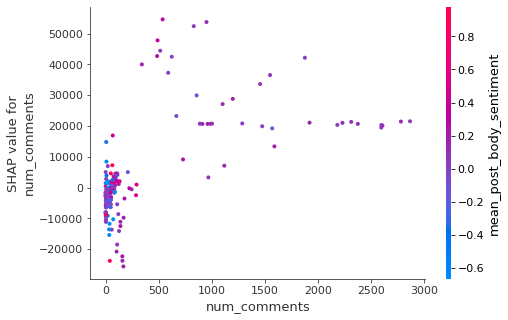

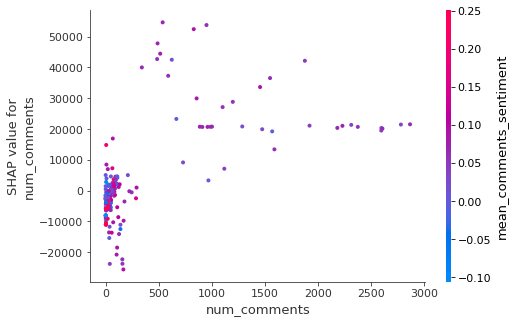

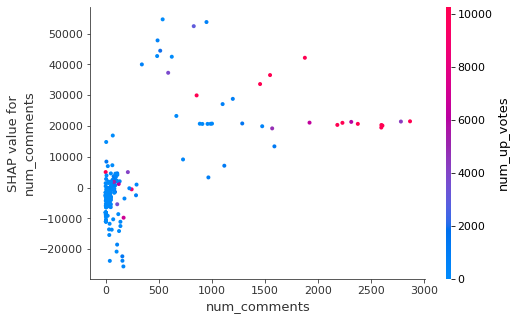

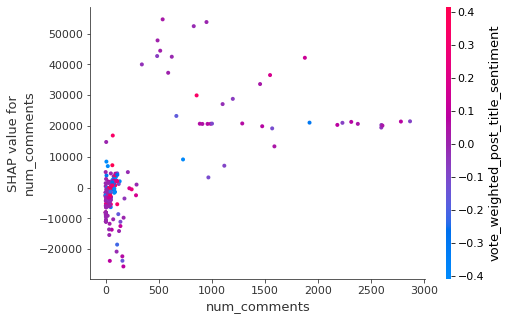

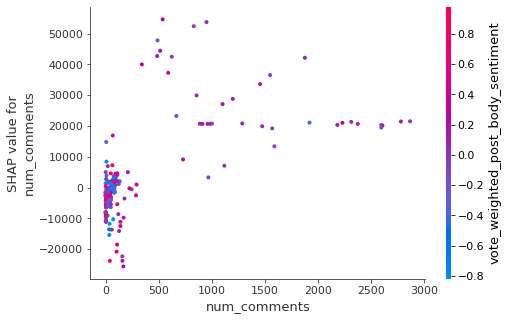

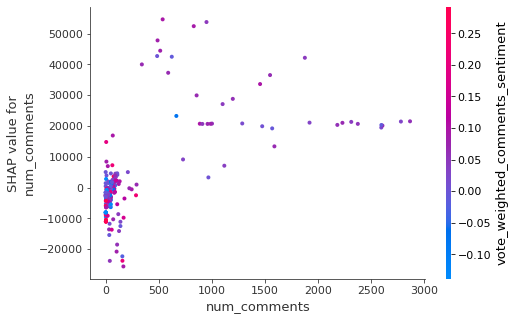

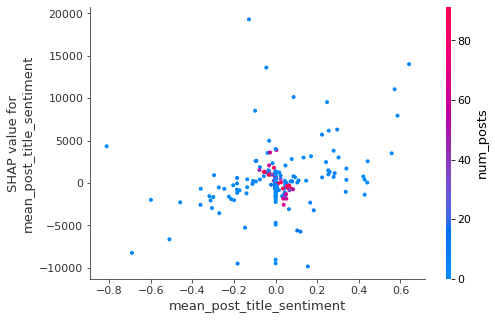

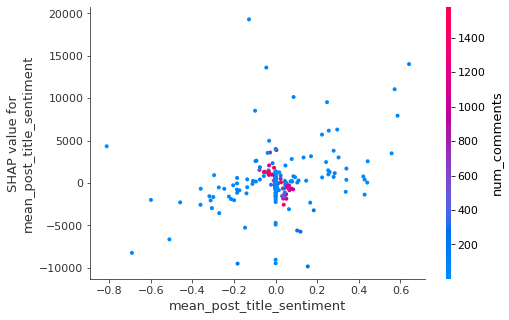

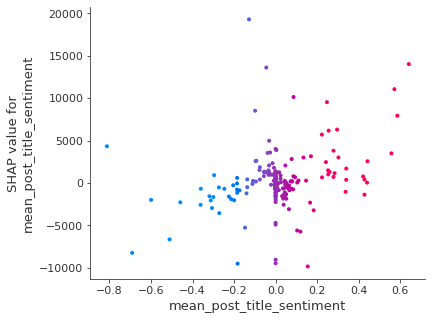

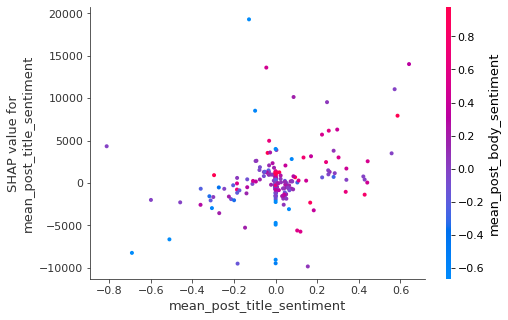

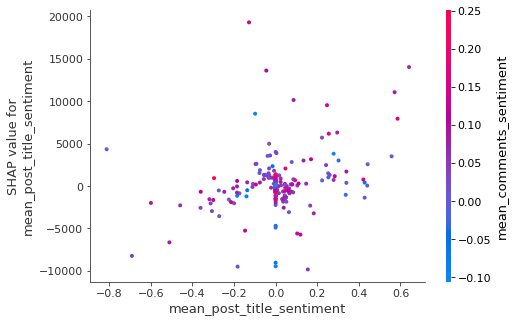

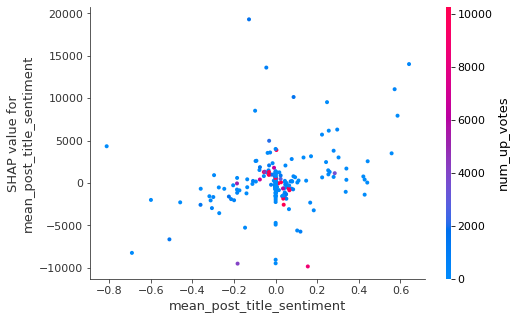

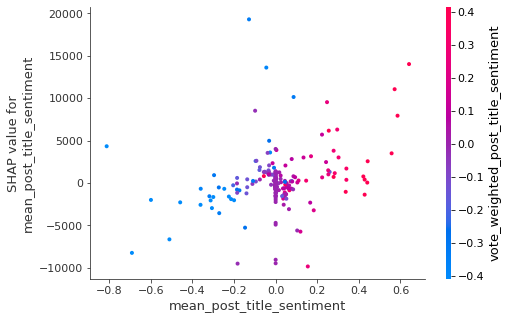

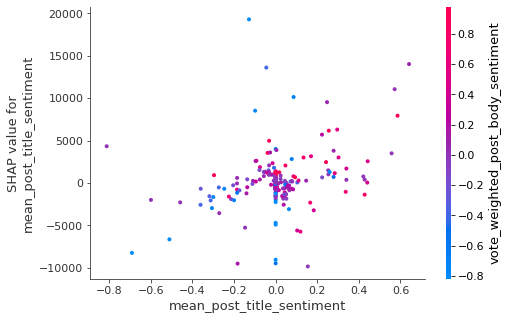

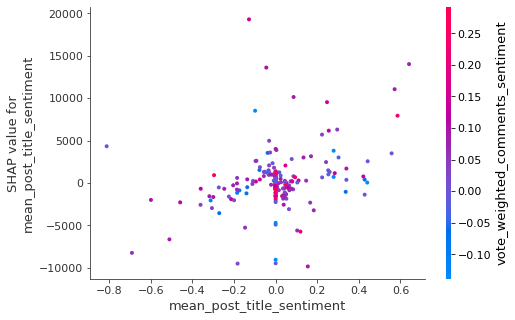

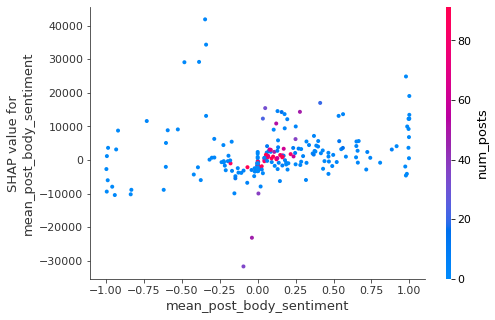

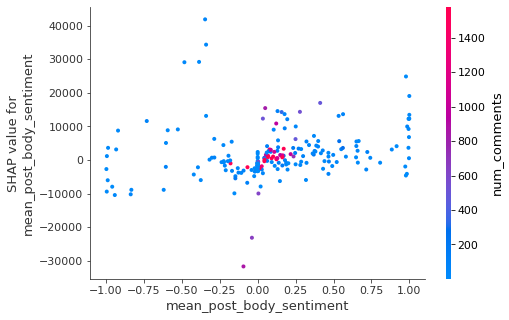

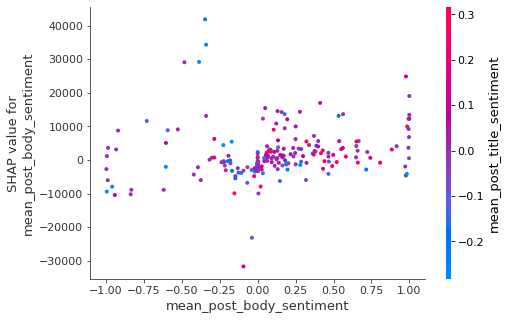

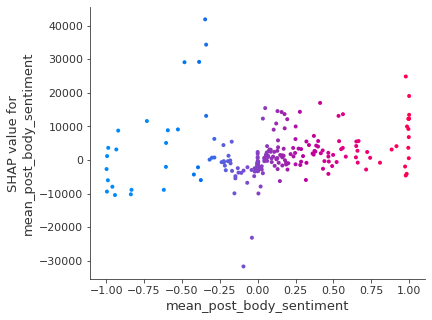

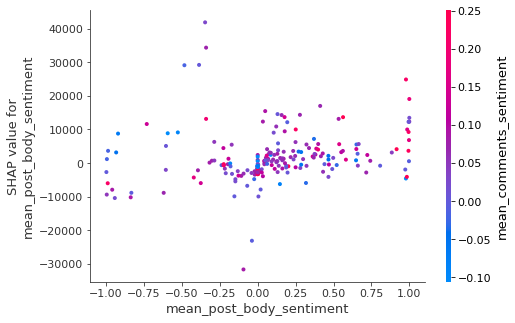

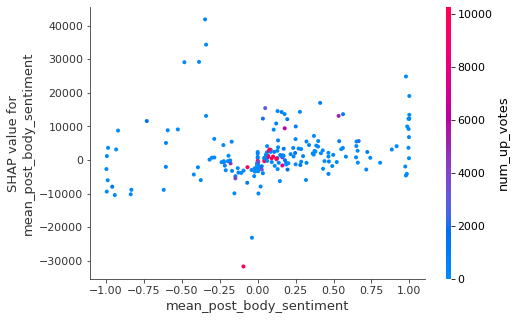

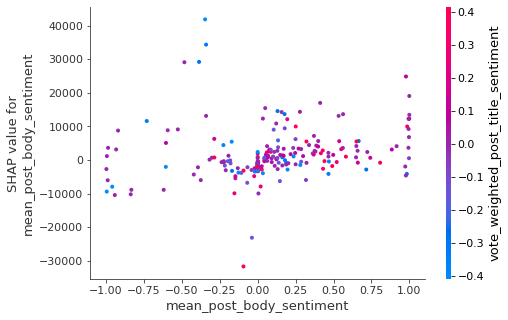

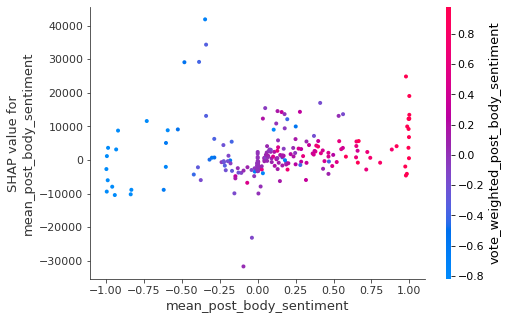

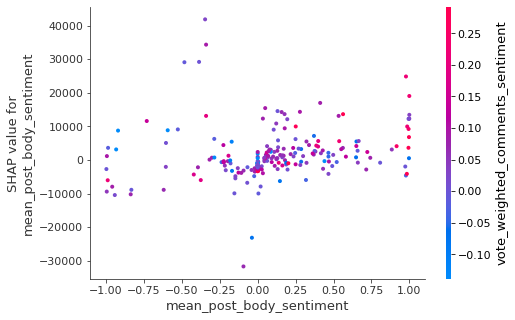

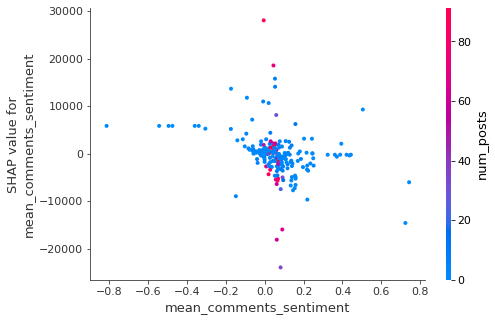

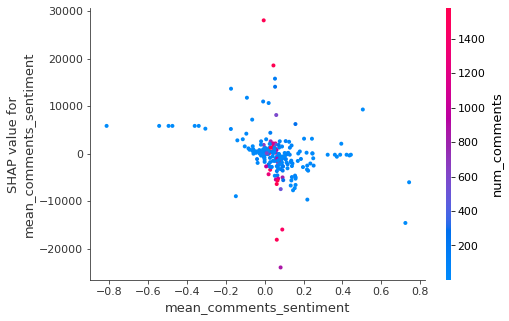

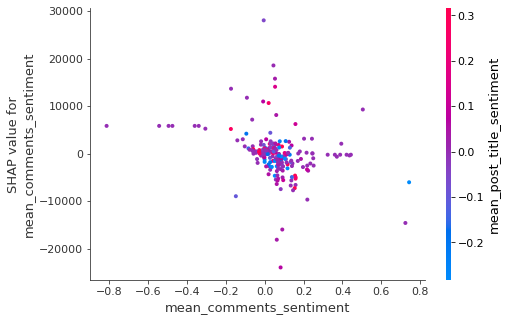

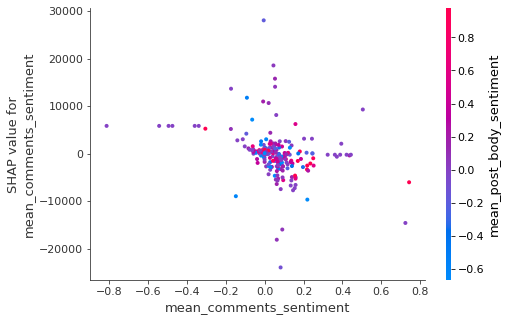

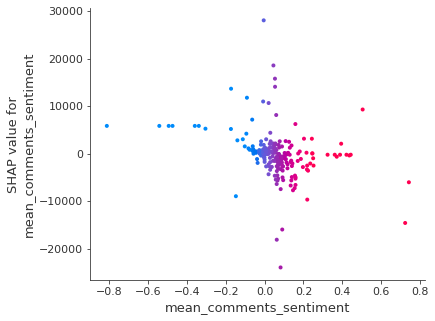

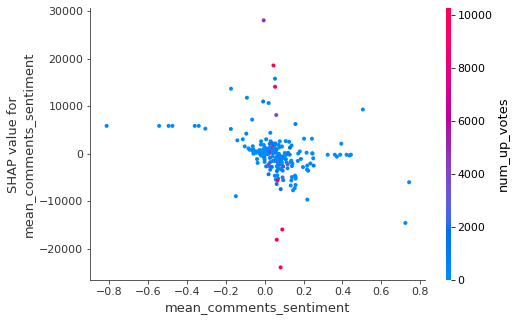

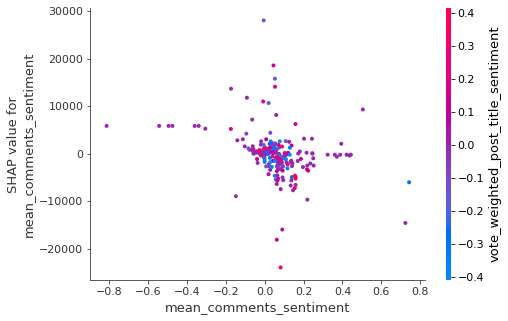

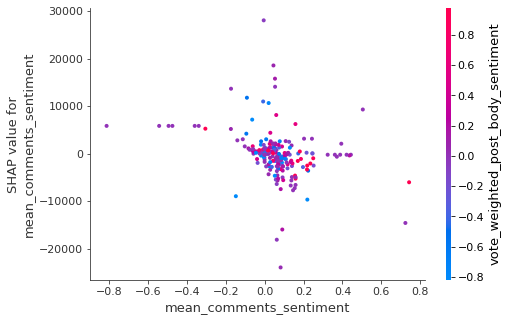

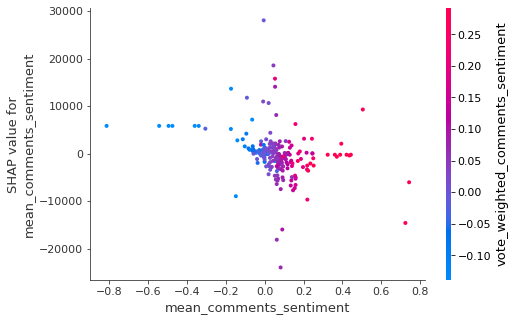

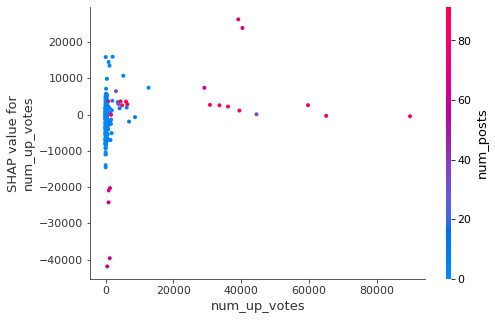

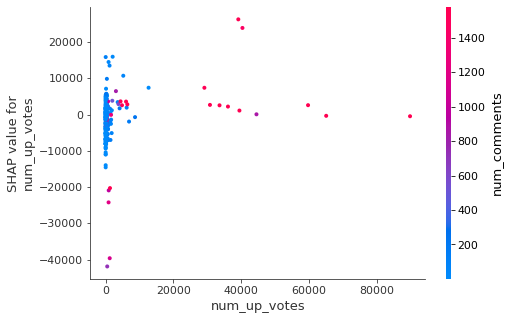

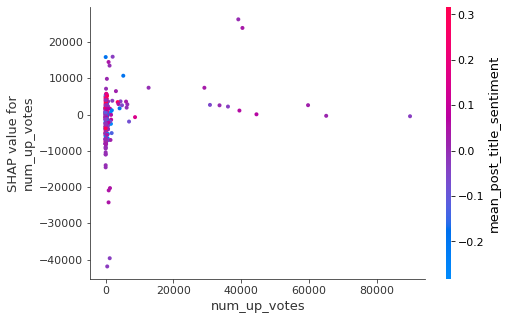

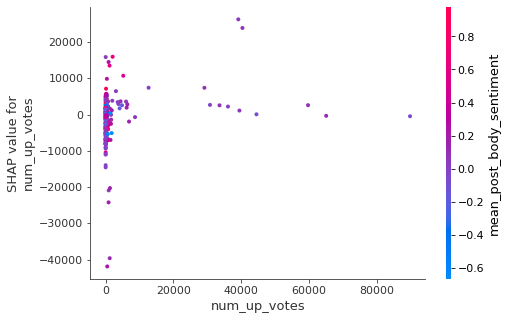

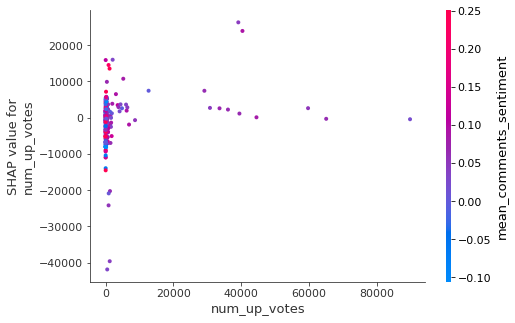

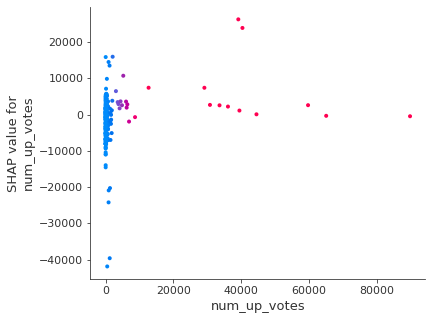

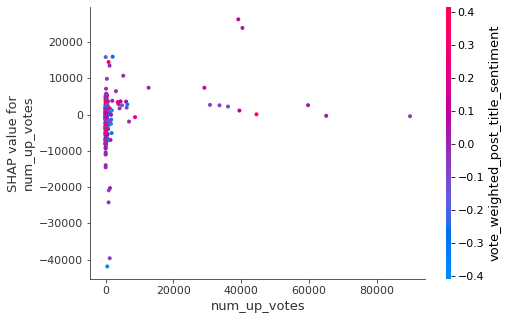

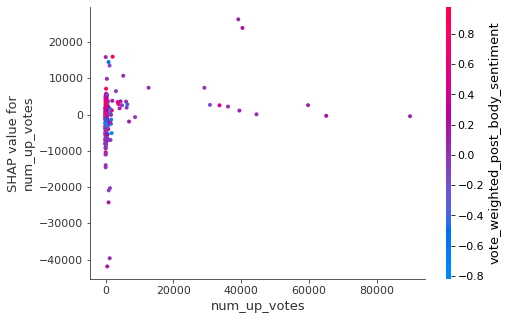

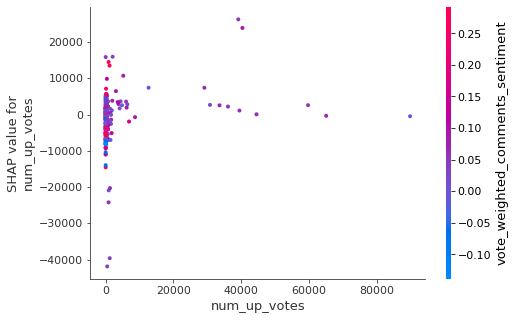

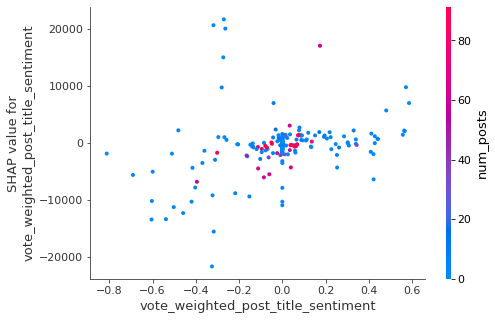

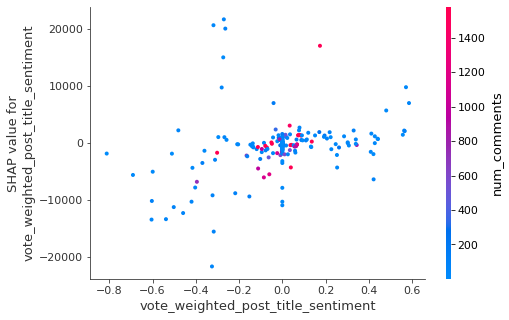

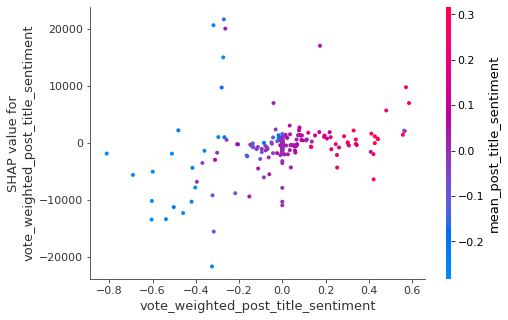

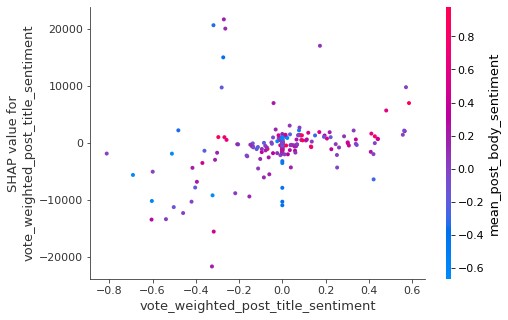

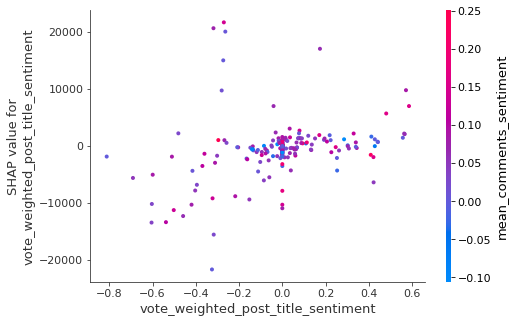

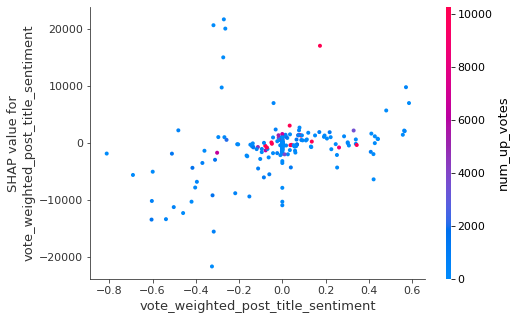

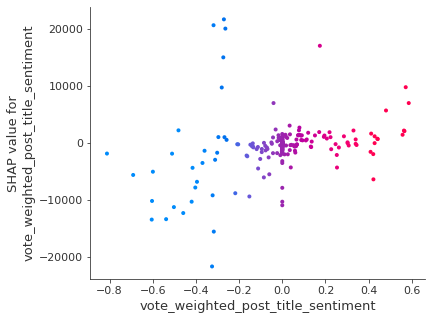

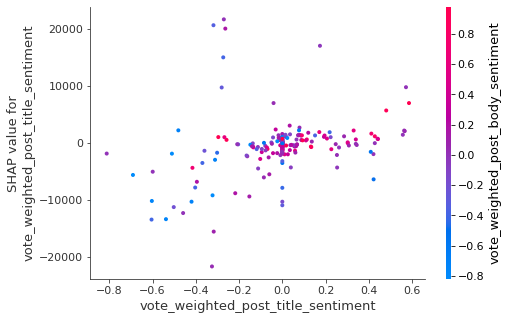

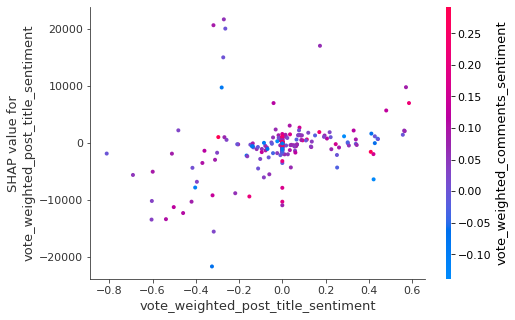

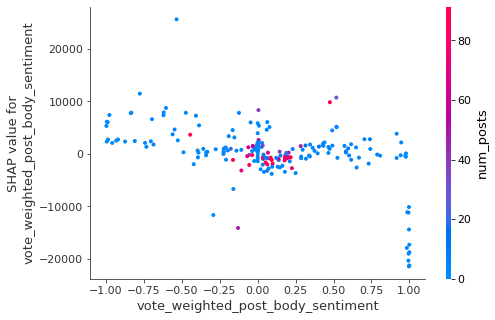

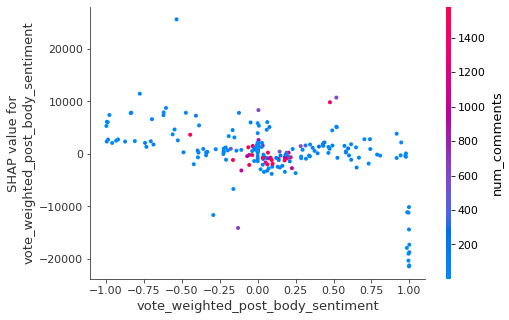

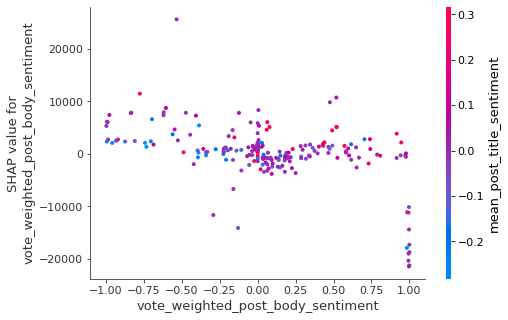

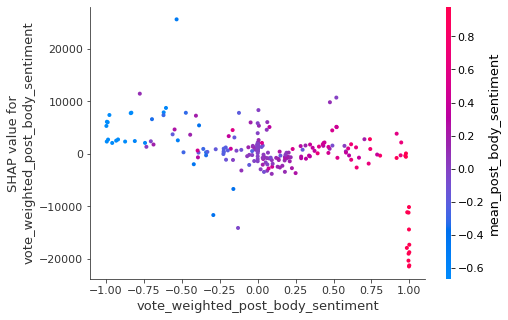

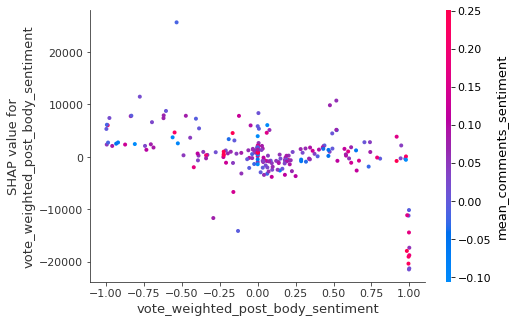

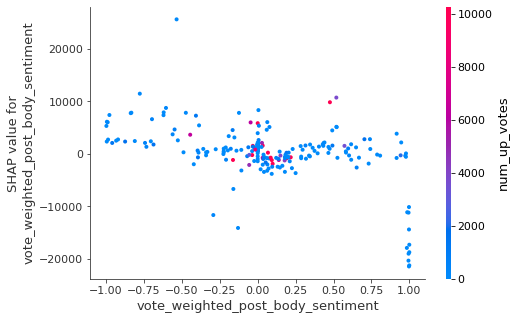

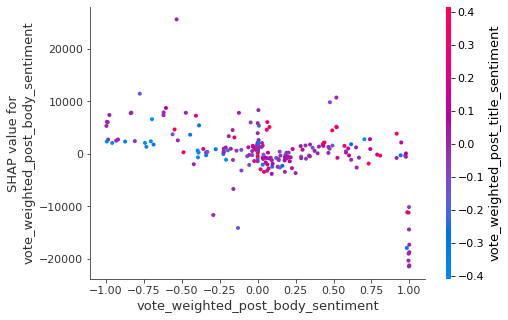

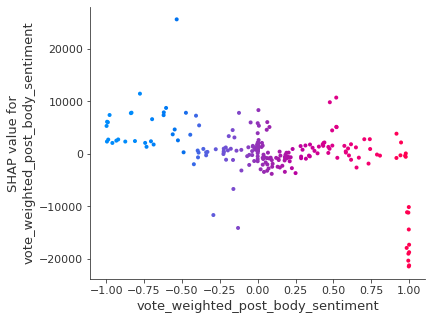

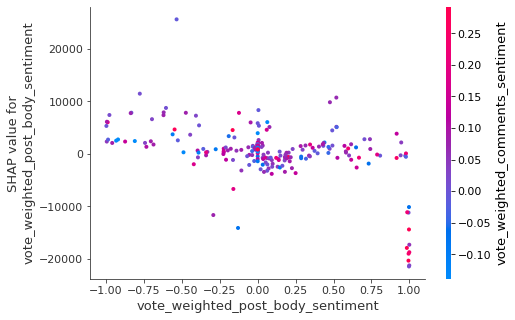

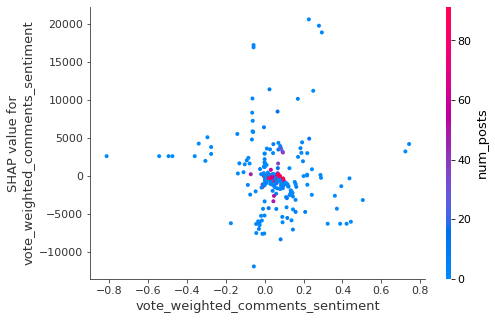

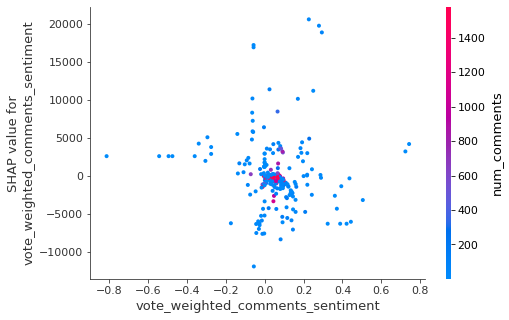

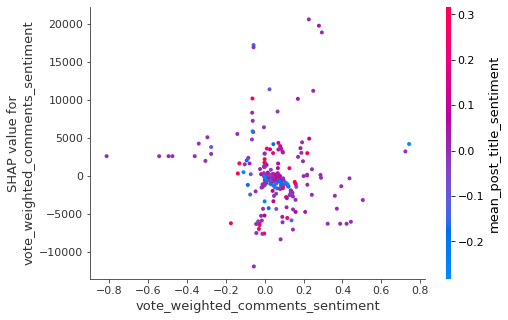

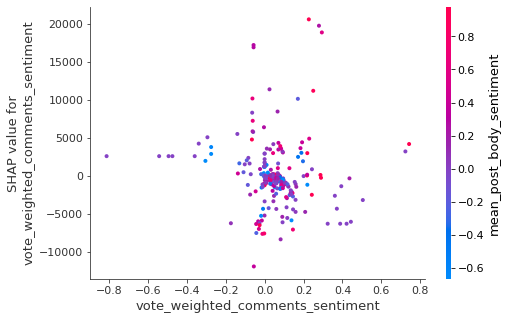

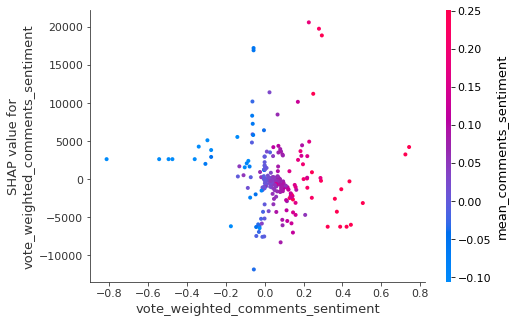

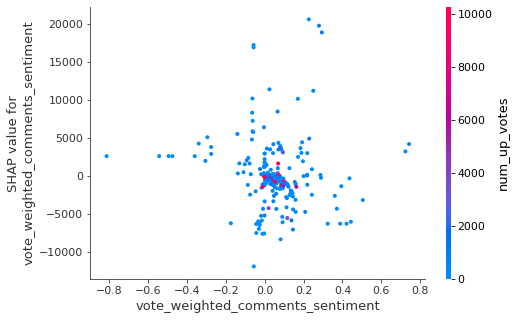

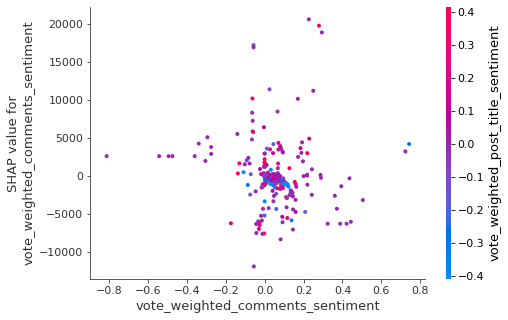

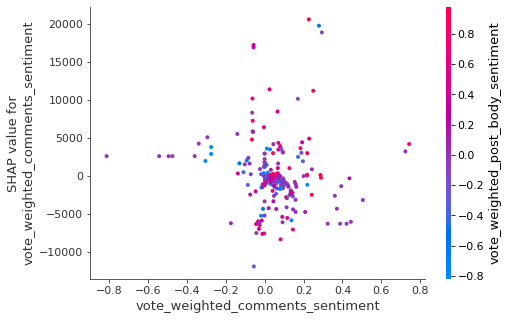

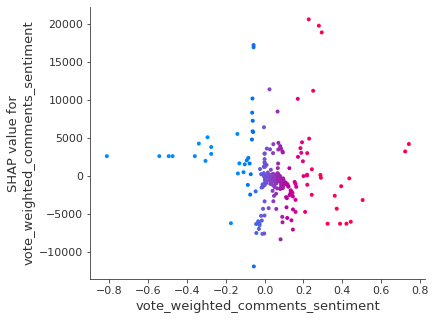

In [53]:
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(x, shap_values, Xv, interaction_index=y)

***

# Make data - excluded post body sentiment scores, s,  for which abs(s) <=0.05

In [54]:
Xt, Xv, yt, yv = train_test_split(X_nonzero_2, Y_nonzero_2, test_size=0.2)

# OLS

In [55]:
def print_accuracy(f):
    print("Root mean squared test error = {0}".format(np.sqrt(np.mean((f(Xt) - yt)**2))))
    time.sleep(0.5) # to let the print get out before any progress bars

In [56]:
Xt_summary = shap.kmeans(Xt, 10)

In [57]:
lin_reg = linear_model.LinearRegression()
lin_reg.fit(Xt, yt)

print_accuracy(lin_reg.predict)

Root mean squared test error = 90598.47585716634


In [58]:
ex = shap.KernelExplainer(lin_reg.predict, Xt_summary)
shap_values = ex.shap_values(Xt.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, Xt.iloc[0,:])

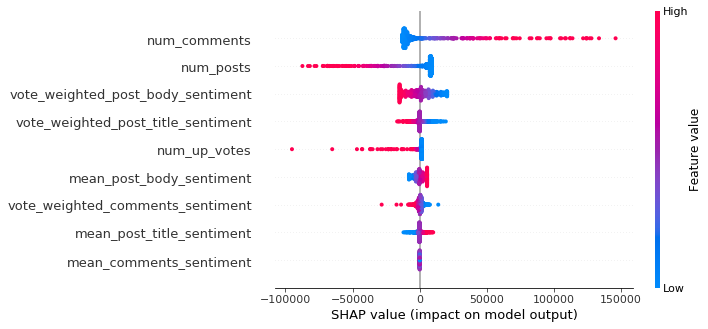

In [59]:
shap_values = ex.shap_values(Xt)
shap.summary_plot(shap_values, Xt)

In [60]:
shap_values.shape, Xv.shape

((658, 9), (165, 9))

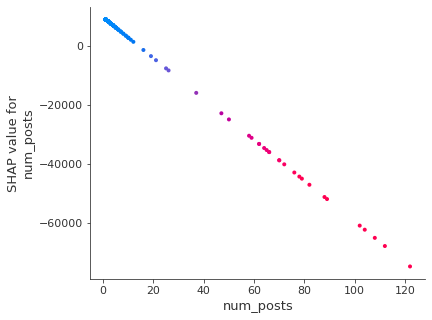

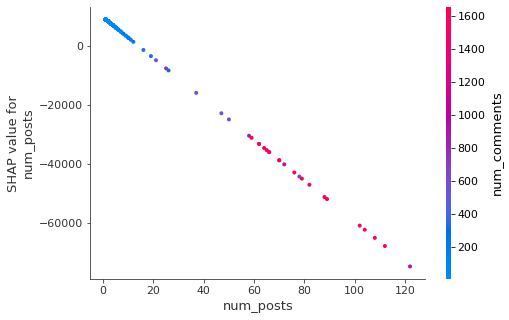

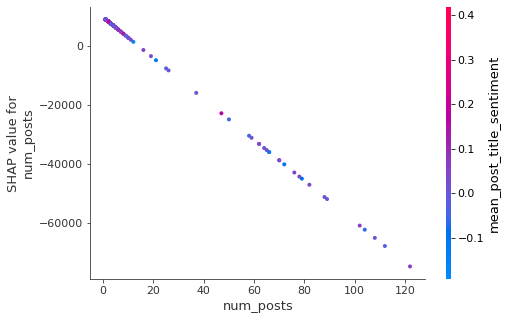

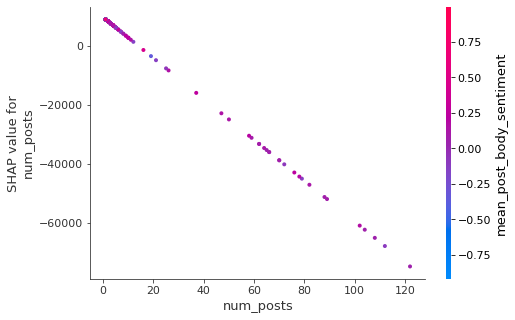

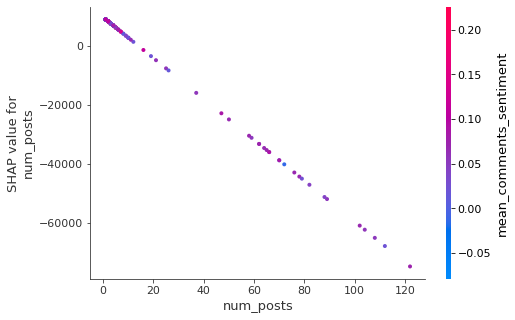

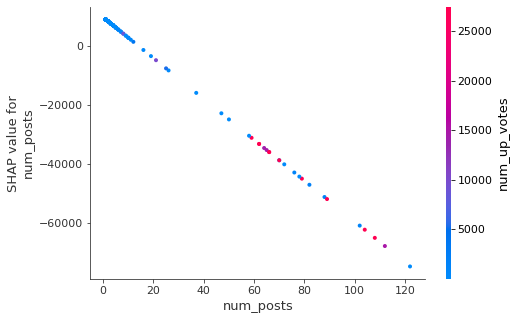

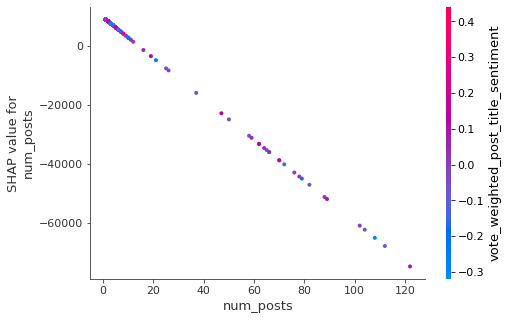

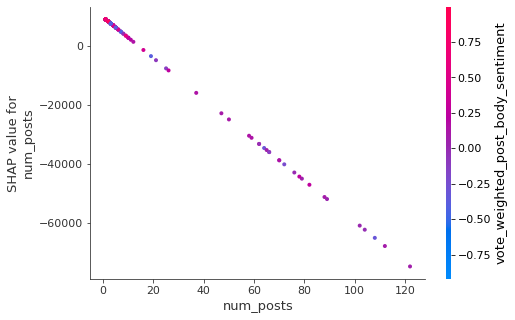

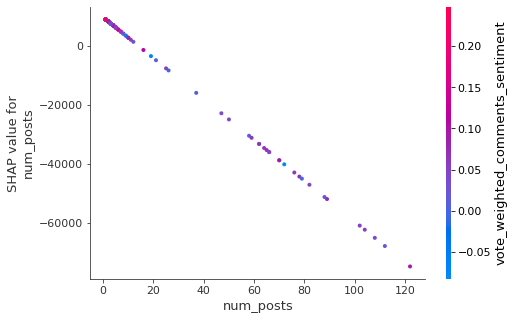

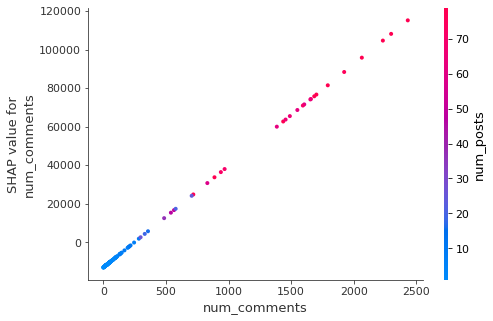

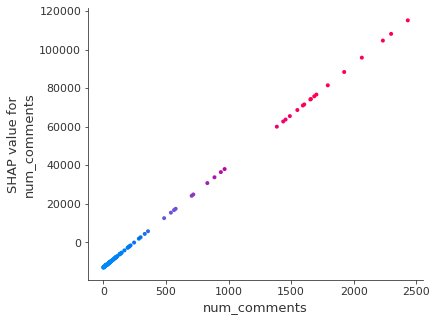

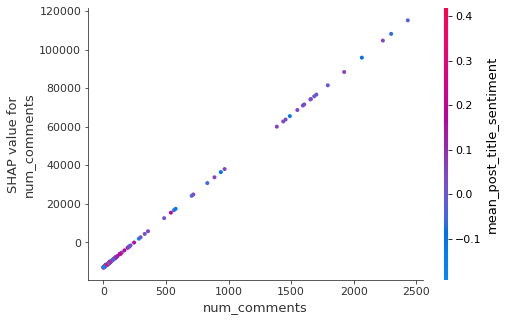

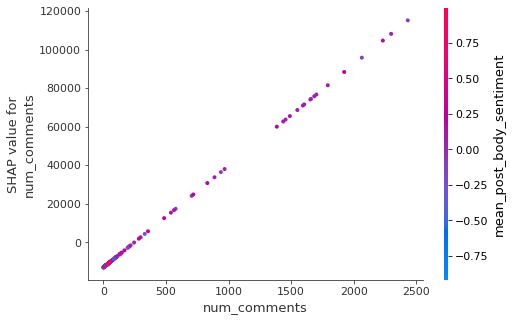

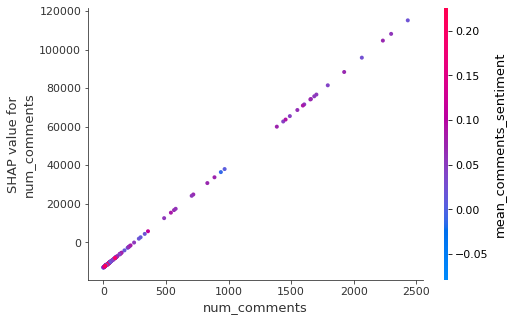

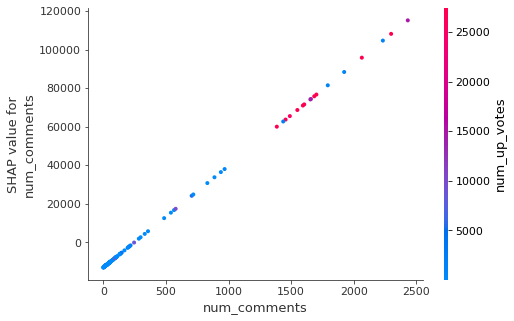

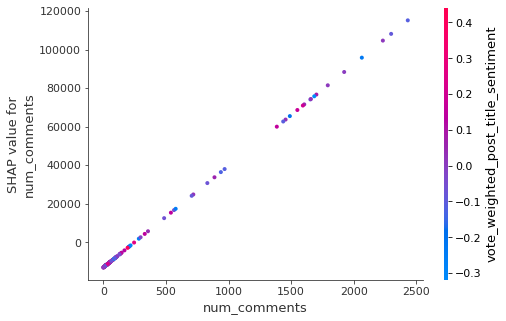

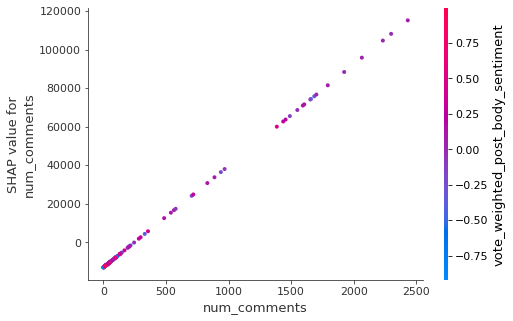

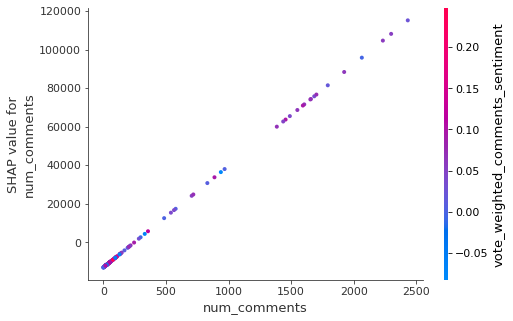

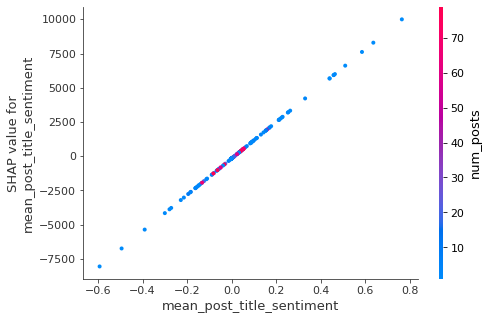

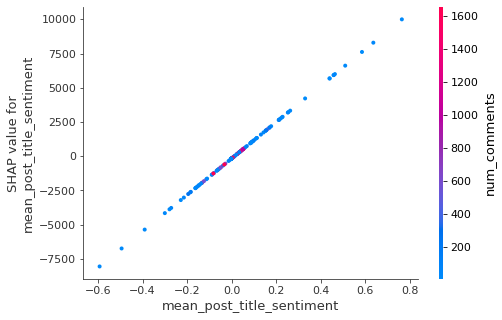

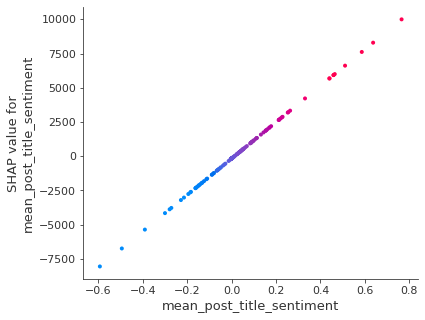

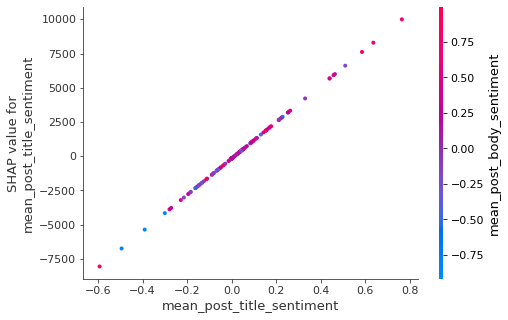

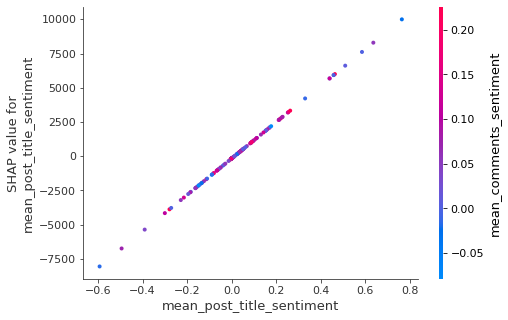

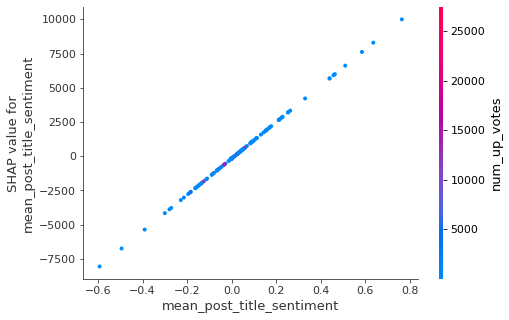

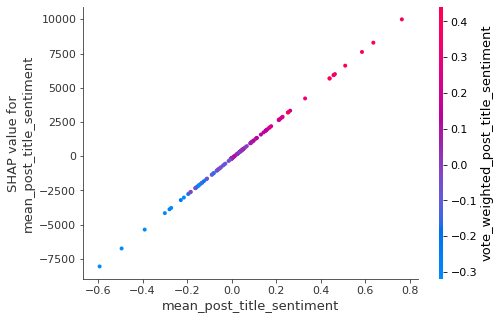

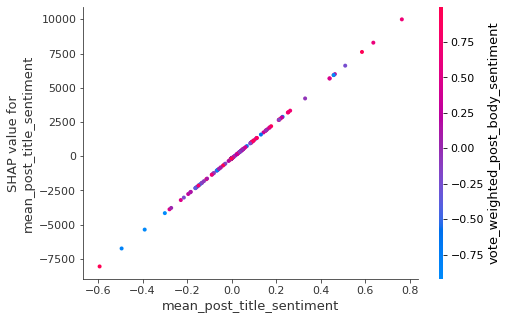

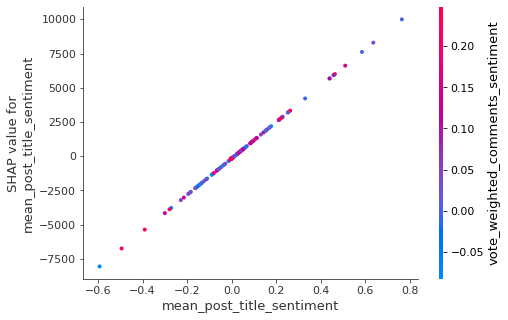

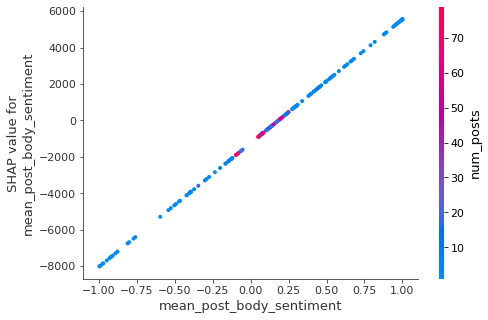

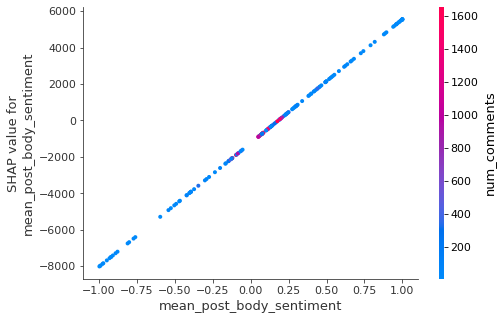

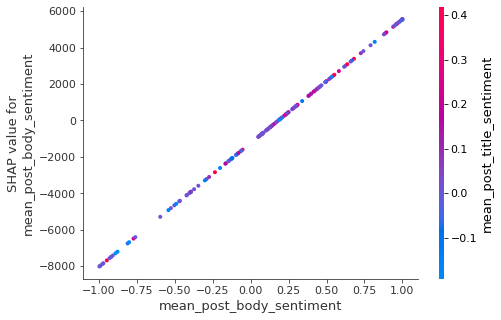

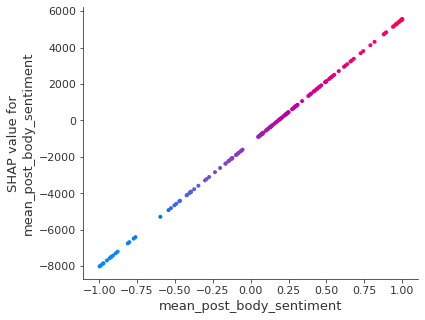

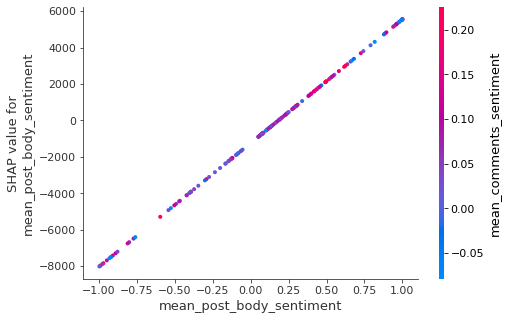

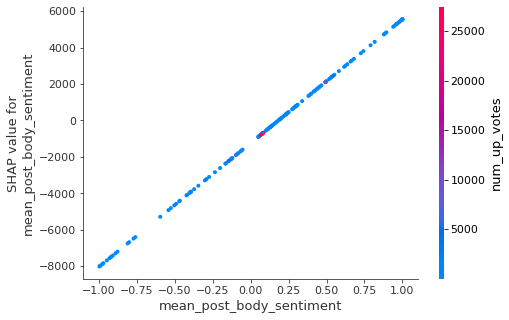

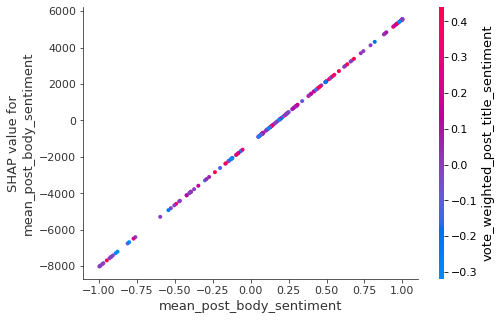

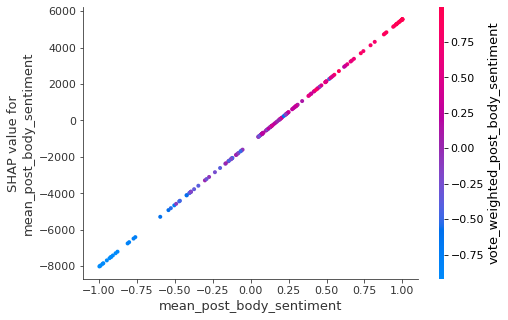

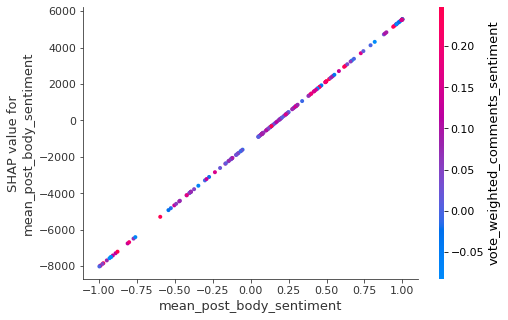

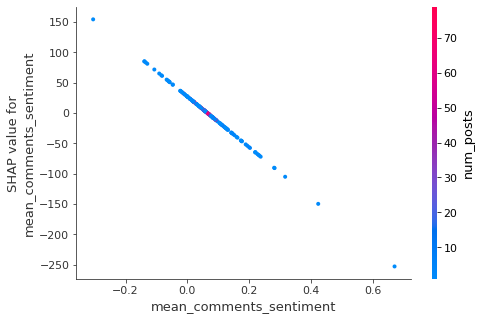

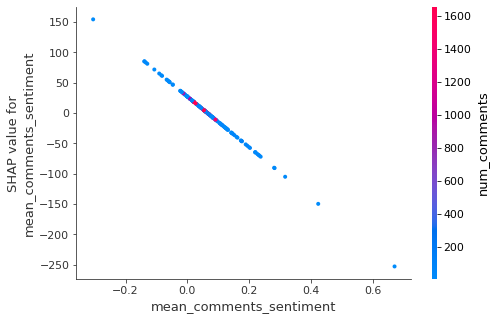

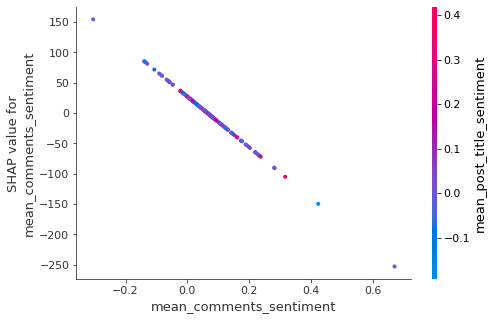

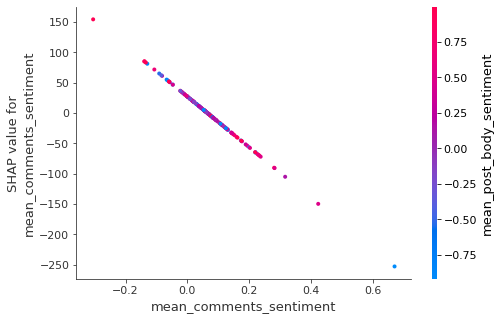

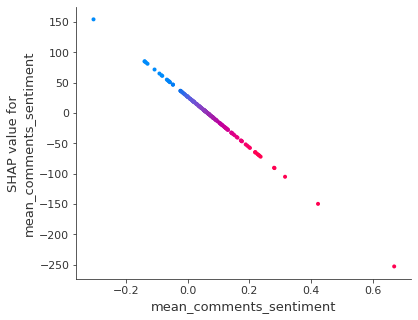

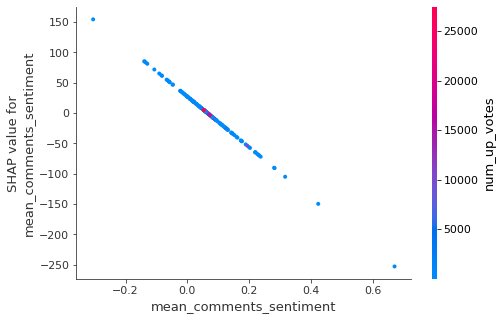

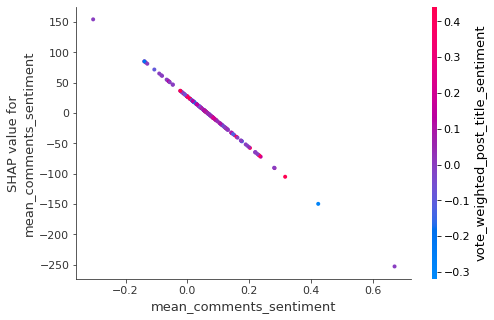

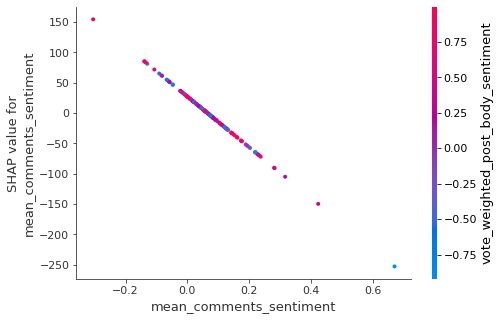

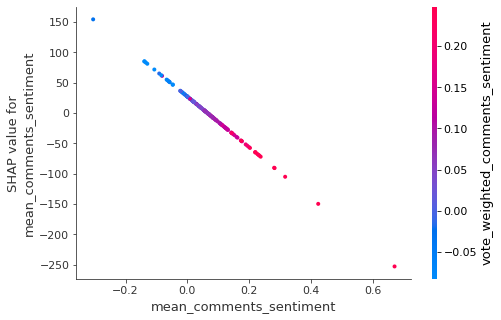

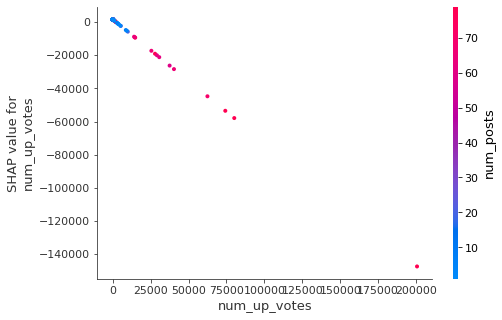

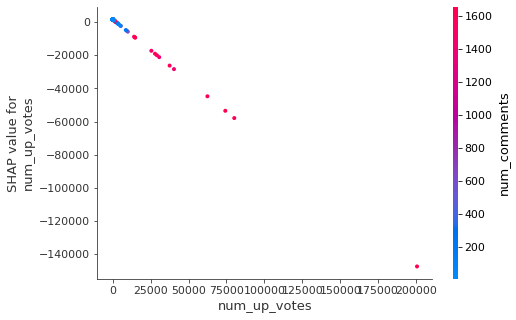

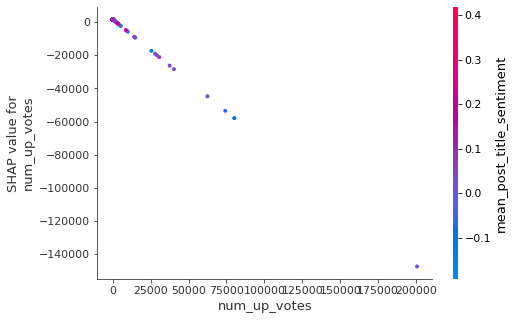

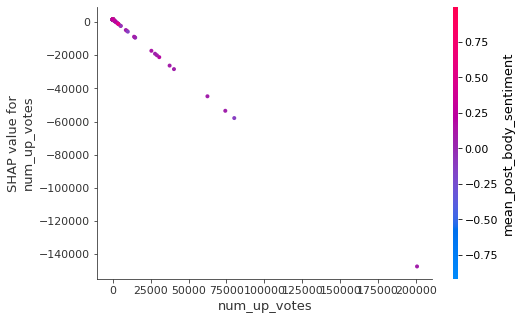

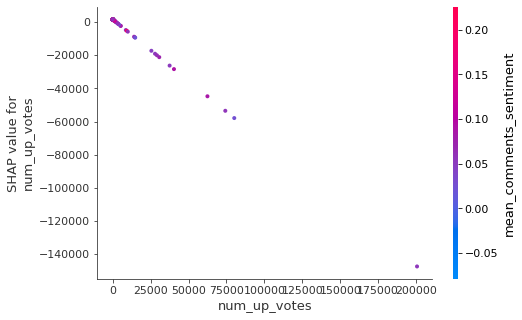

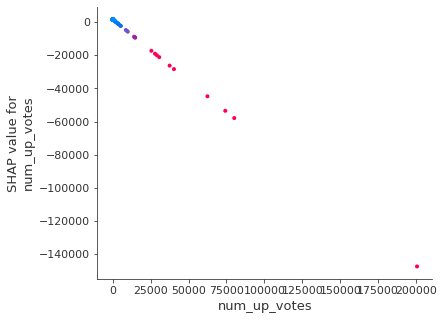

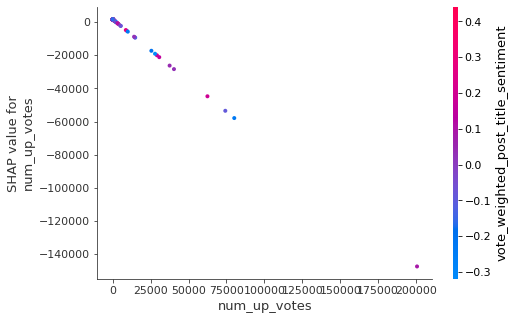

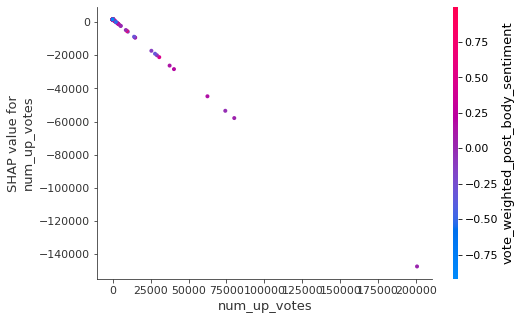

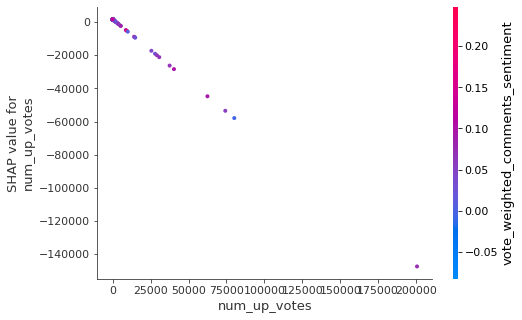

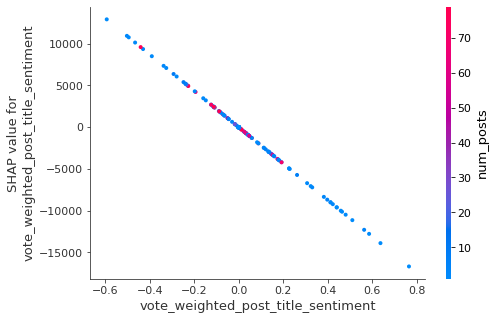

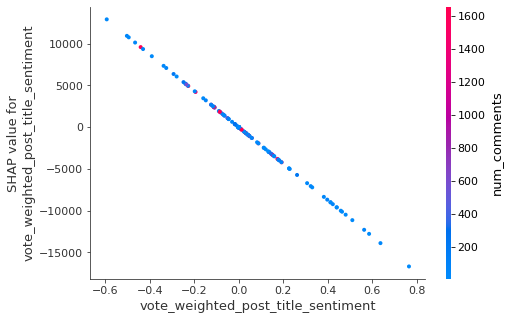

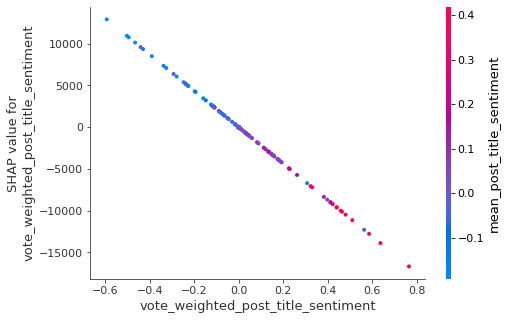

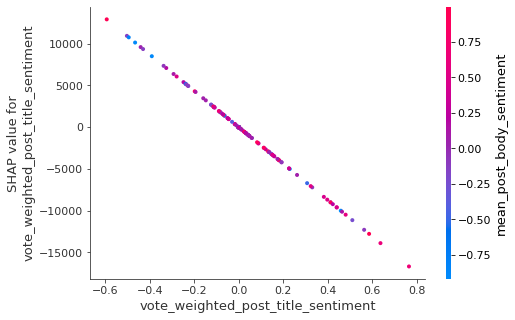

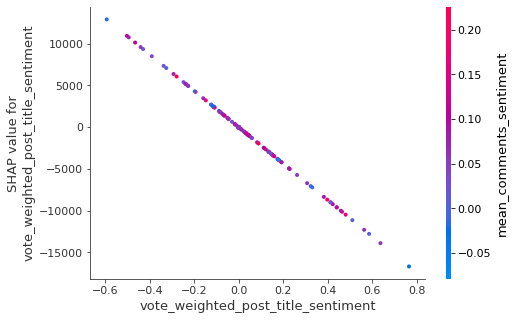

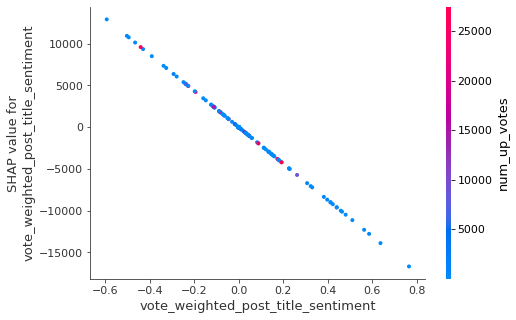

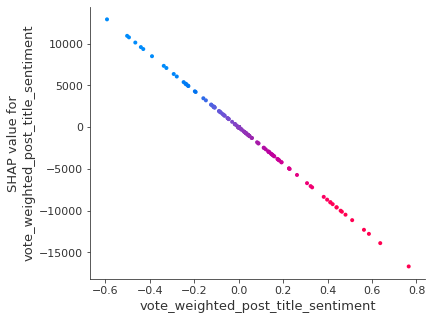

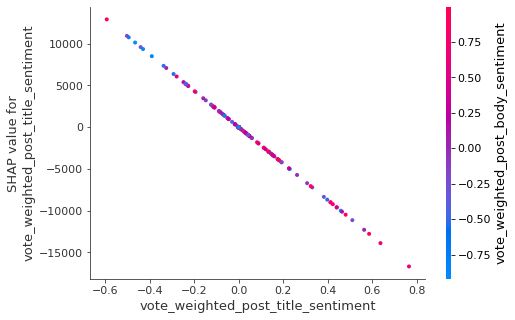

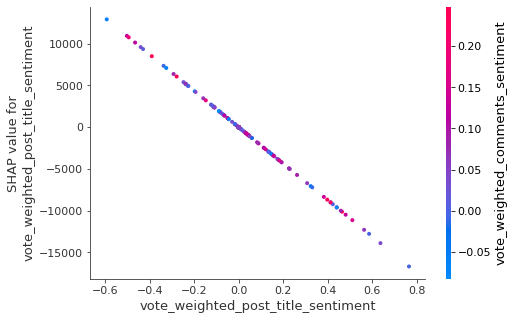

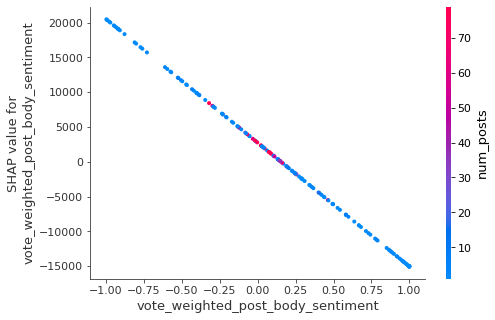

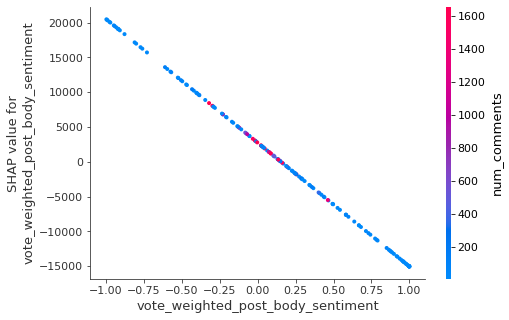

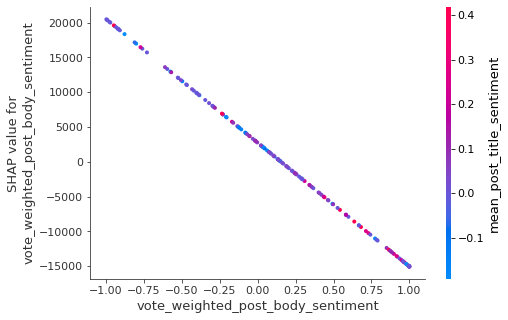

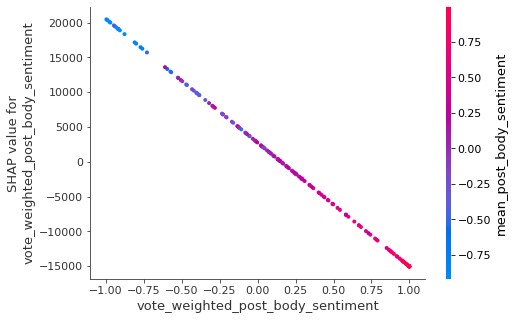

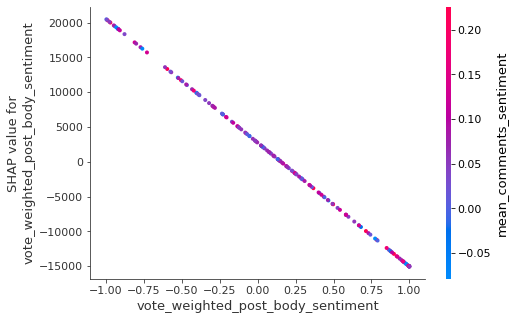

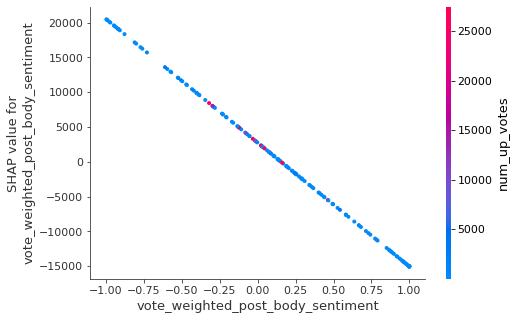

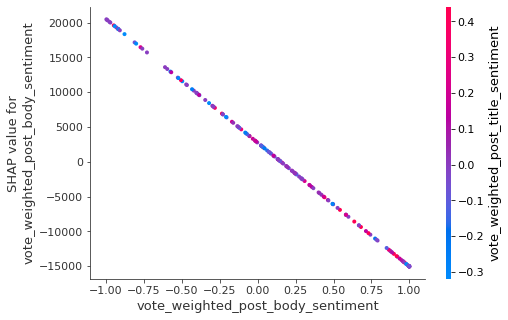

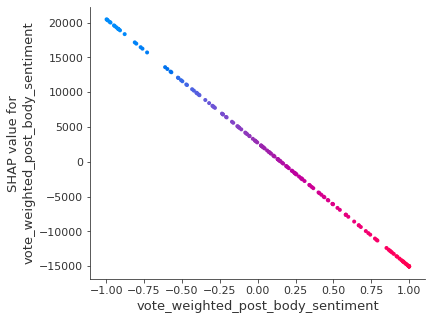

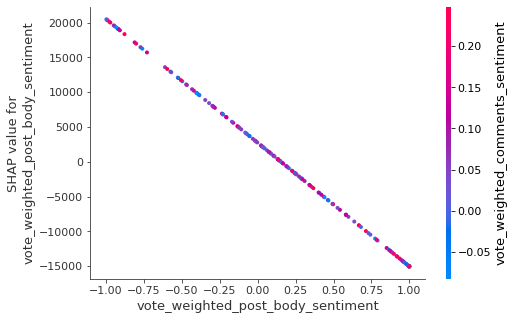

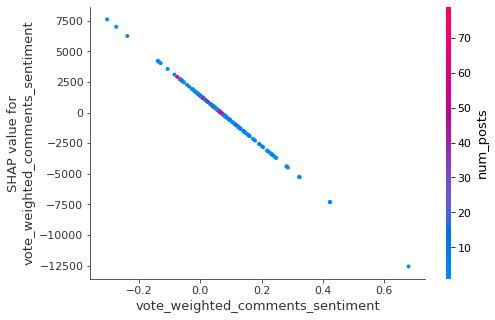

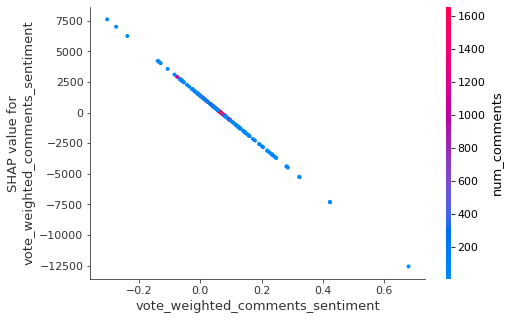

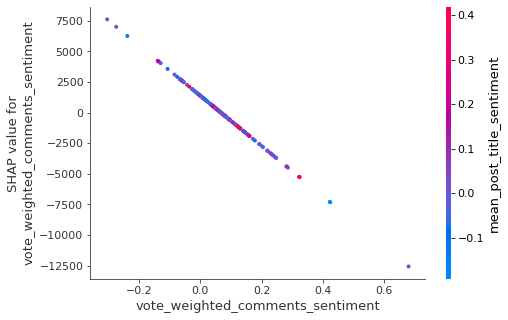

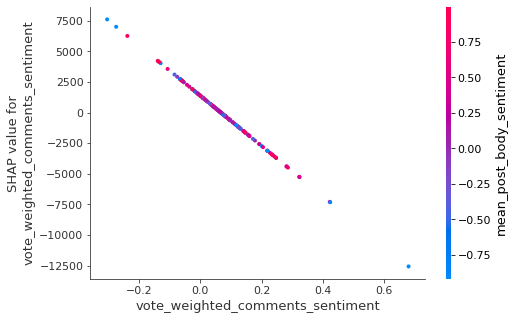

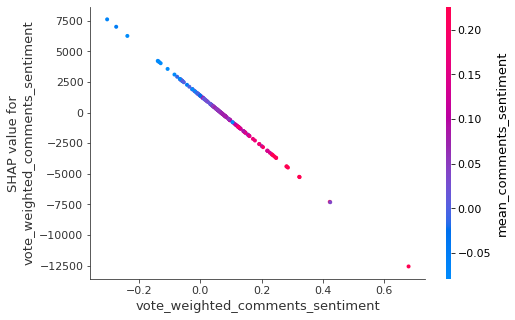

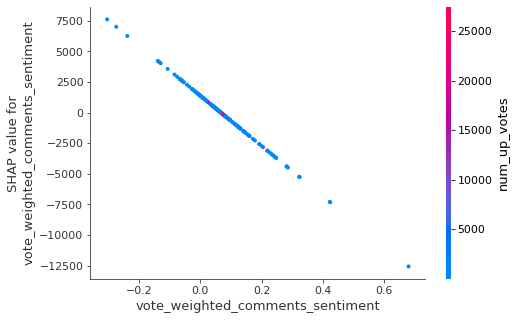

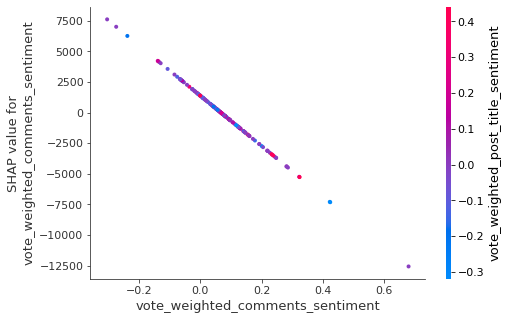

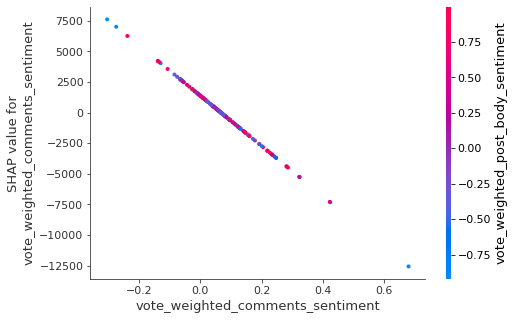

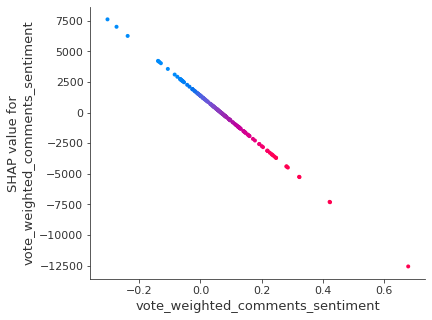

In [61]:
shap_values = ex.shap_values(Xv)
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(x, shap_values, Xv, interaction_index=y)

In [62]:
X_nonzero_2_c = sm.add_constant(X_nonzero_2)
model = sm.OLS(Y_nonzero_2, X_nonzero_2_c) # fitting OLS
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          users_holding   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.544
Date:                Fri, 09 Oct 2020   Prob (F-statistic):              0.128
Time:                        14:47:35   Log-Likelihood:                -10550.
No. Observations:                 823   AIC:                         2.112e+04
Df Residuals:                     813   BIC:                         2.117e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [63]:
Y_nonzero

bin_label
1     102654.473054
2      85357.068182
3     101281.929688
4     121612.552511
5     121418.163333
          ...      
18    112892.344262
30    140587.661538
31    125596.277778
35     80995.100946
38     84526.368263
Name: users_holding, Length: 1163, dtype: float64

***

# XGBoost and SHAP

In [64]:
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [65]:
params = {
    "eta": .3,
    "max_depth": 10,
    "objective": "reg:squarederror",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 3, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[0]	train-logloss:-4.155e+06	valid-logloss:-3.50021e+06
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 5 rounds.
[2]	train-logloss:-4.15499e+06	valid-logloss:-3.50021e+06


In [66]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [67]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

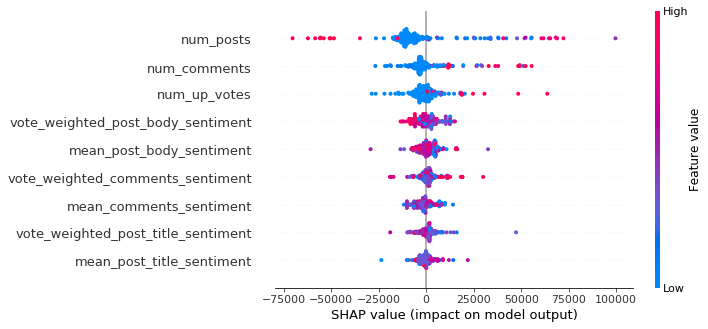

In [68]:
shap.summary_plot(shap_values, Xv)

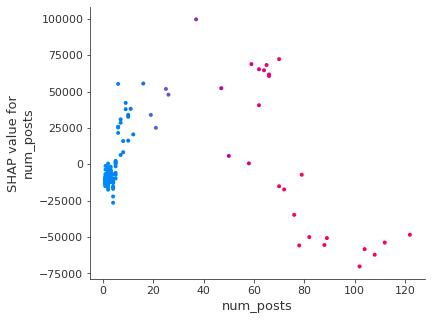

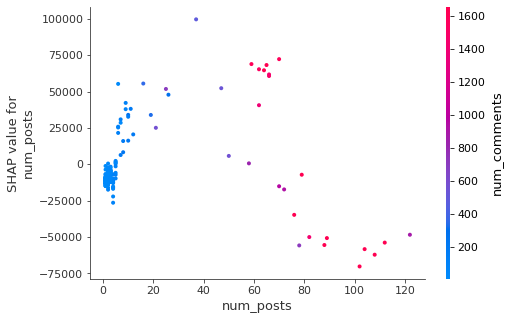

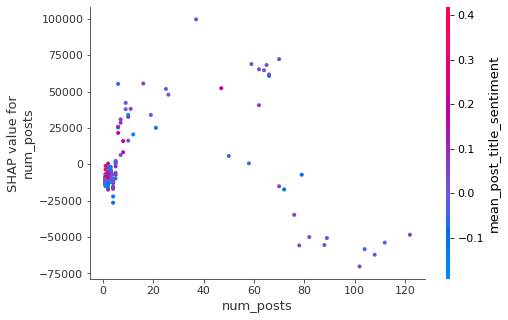

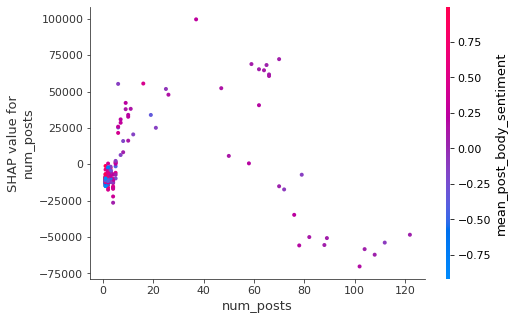

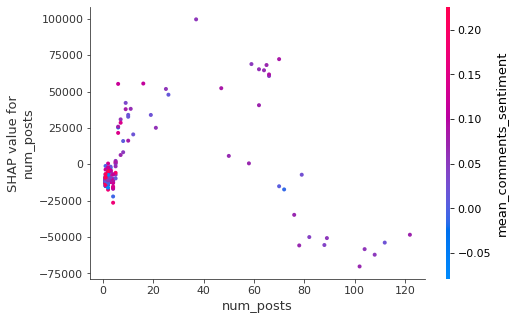

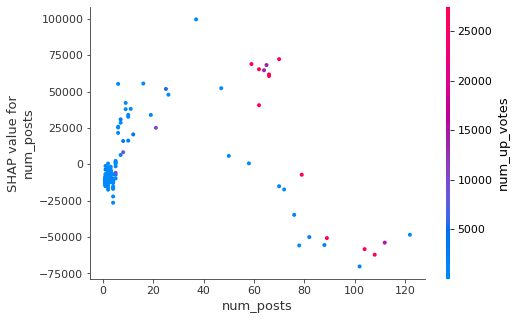

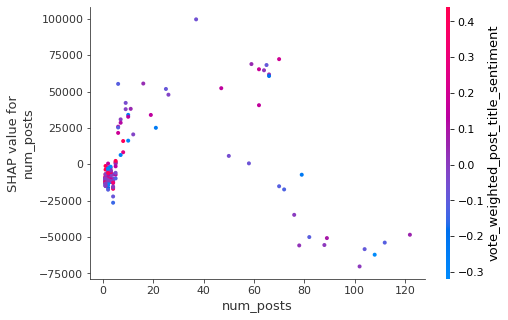

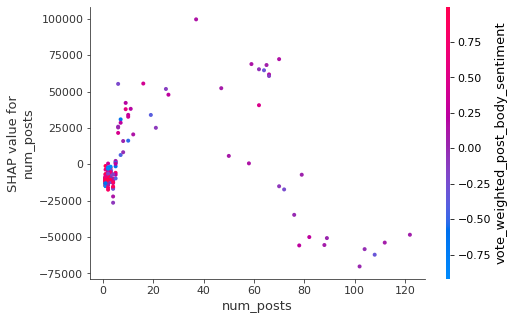

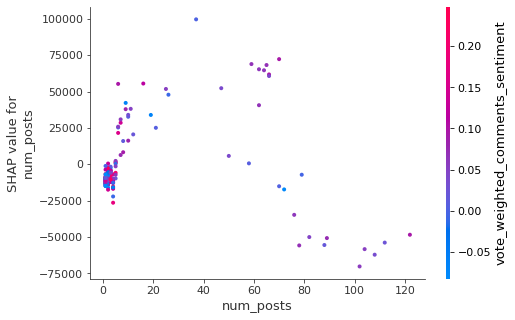

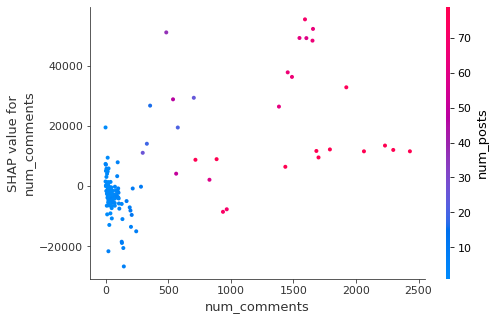

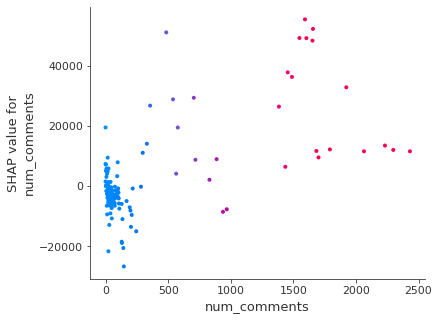

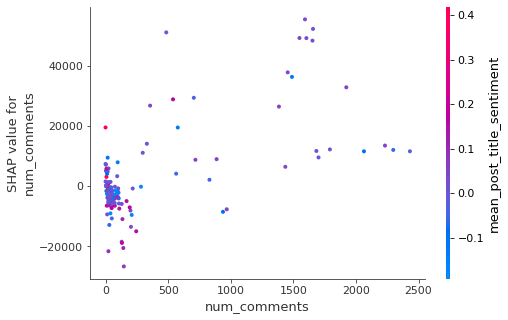

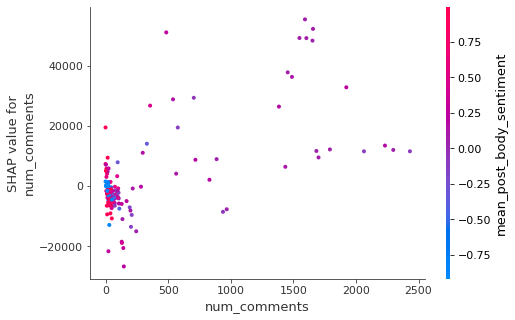

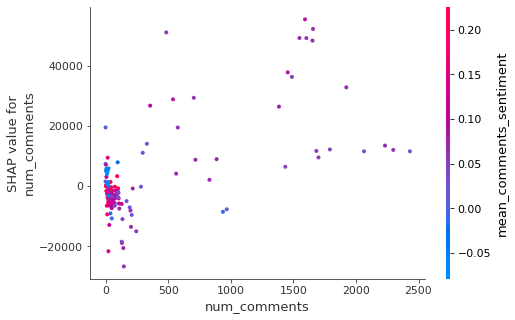

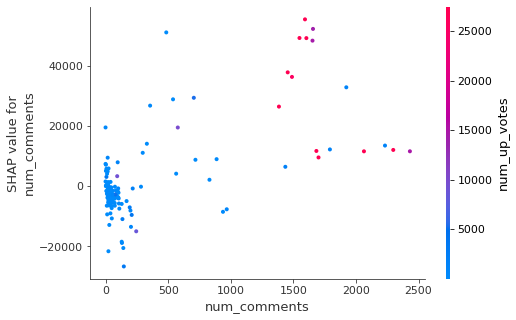

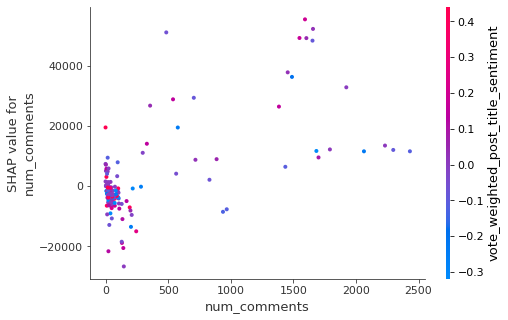

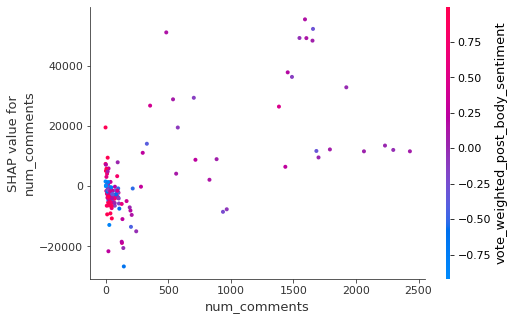

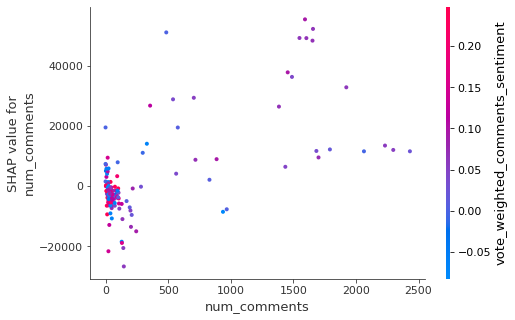

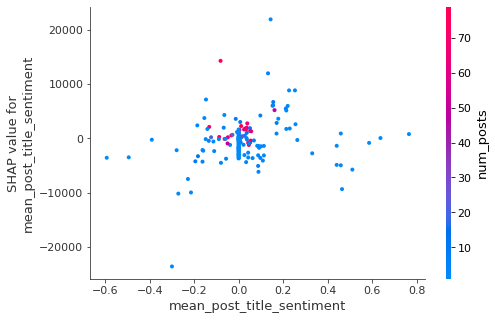

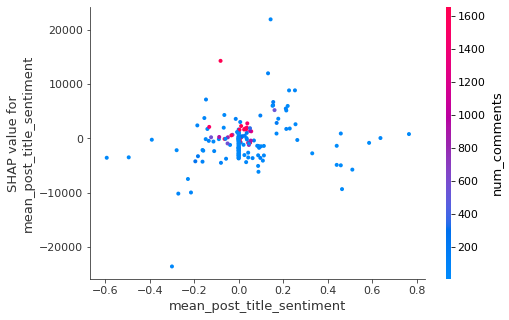

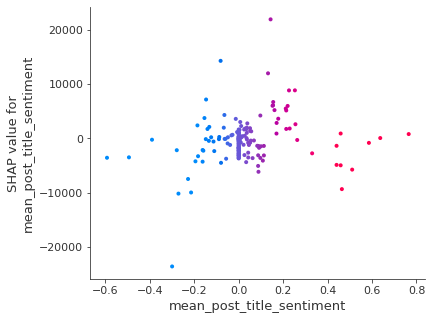

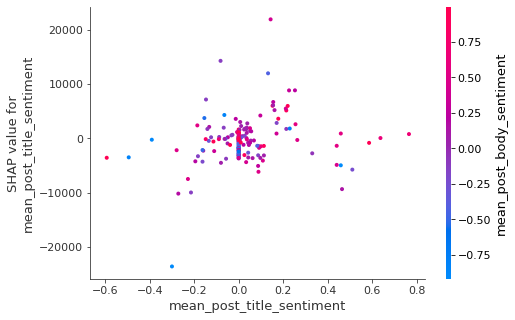

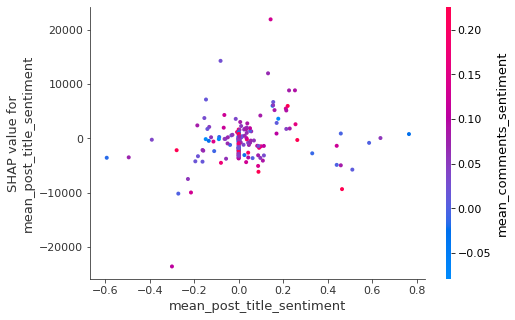

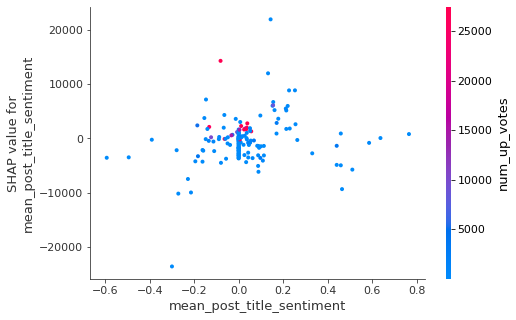

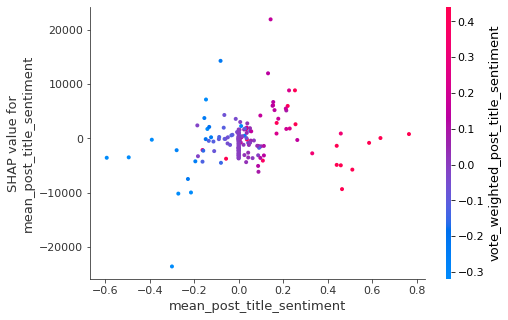

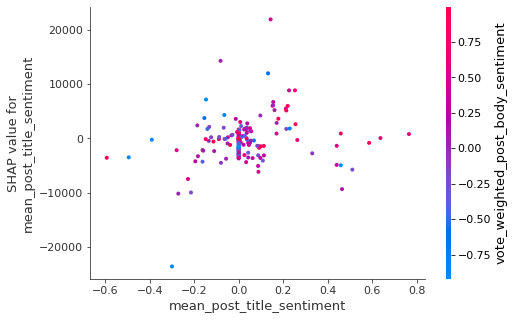

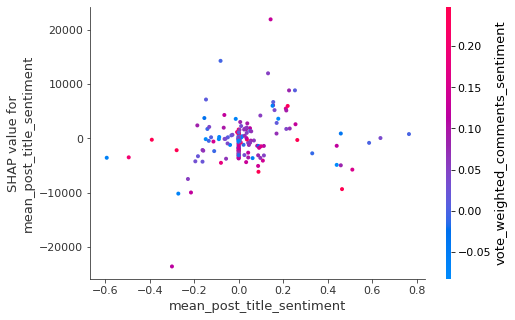

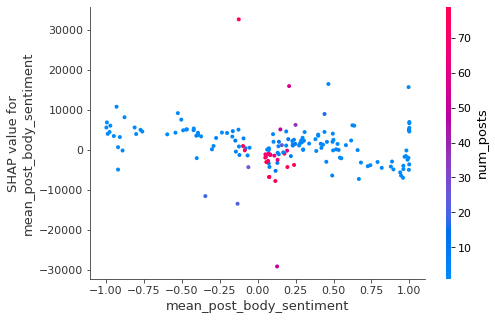

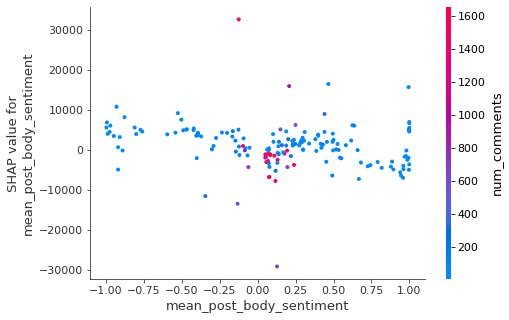

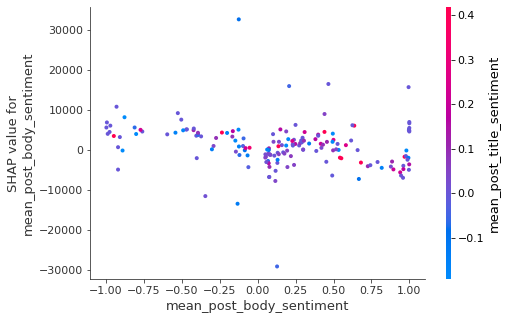

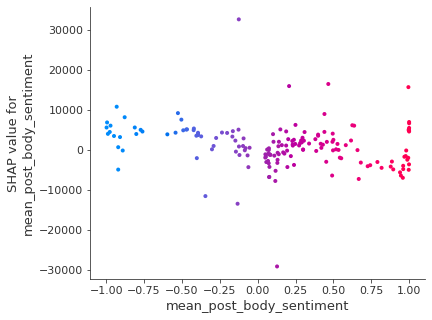

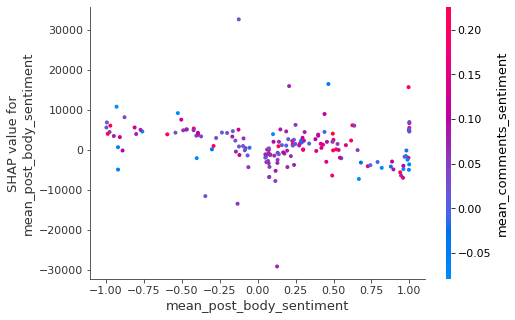

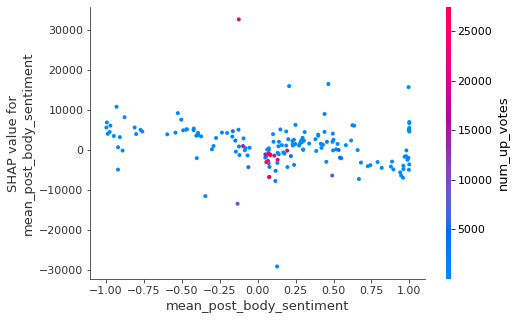

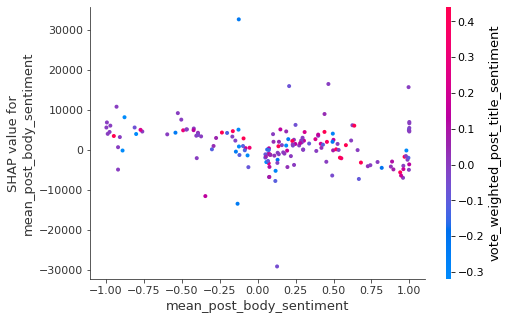

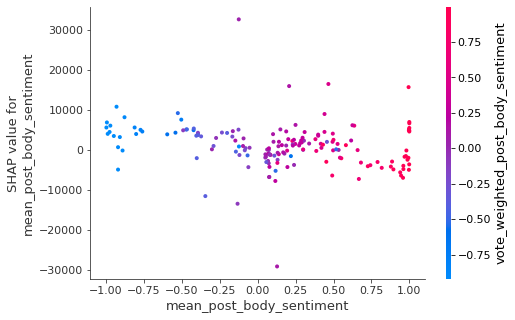

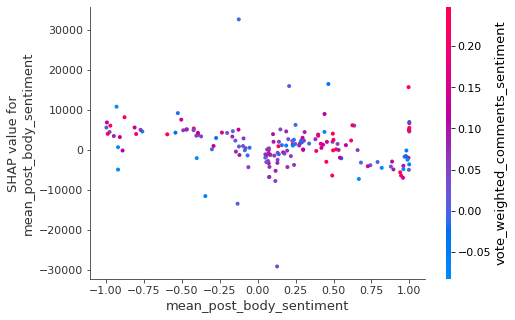

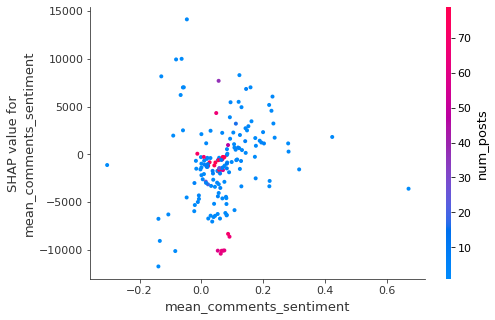

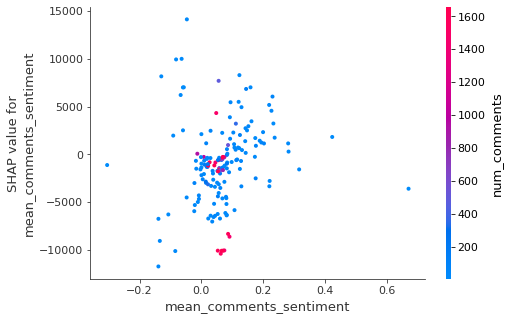

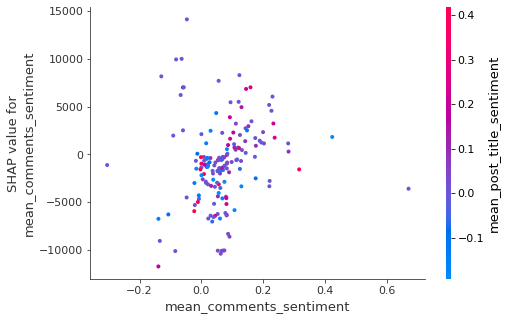

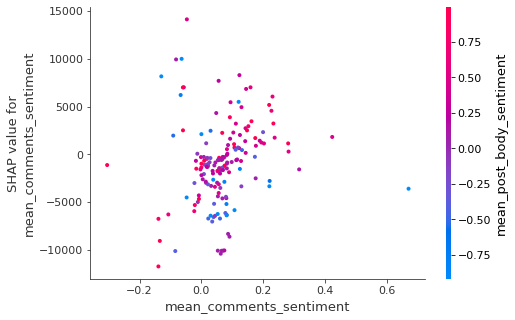

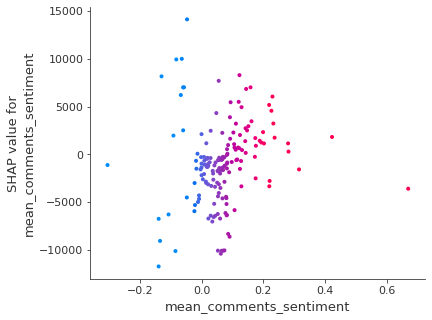

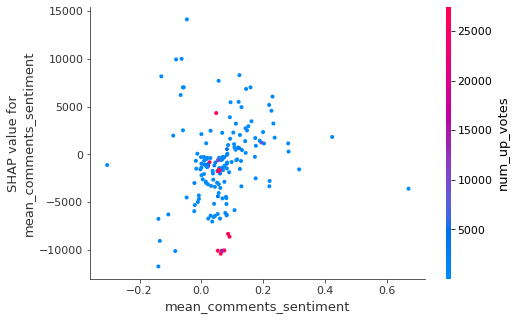

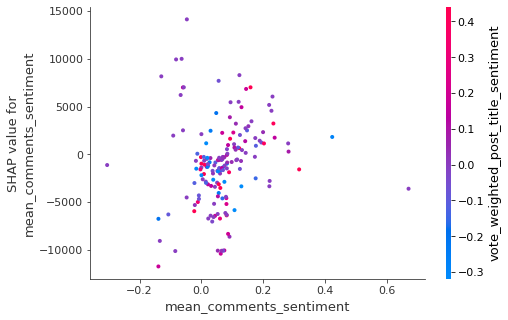

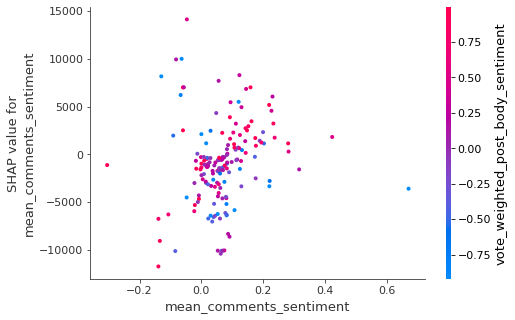

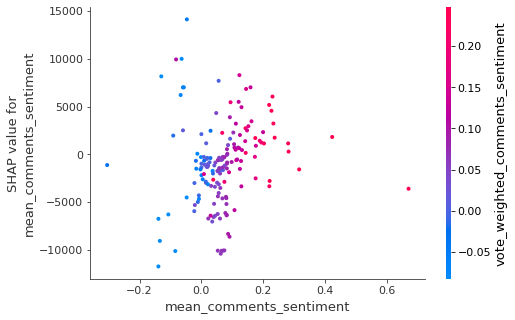

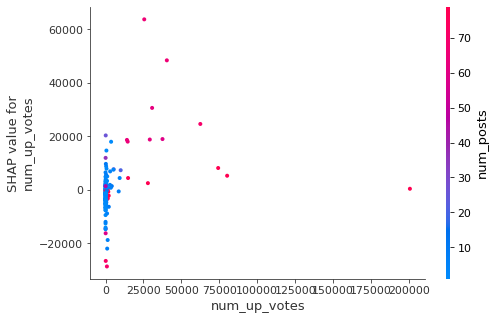

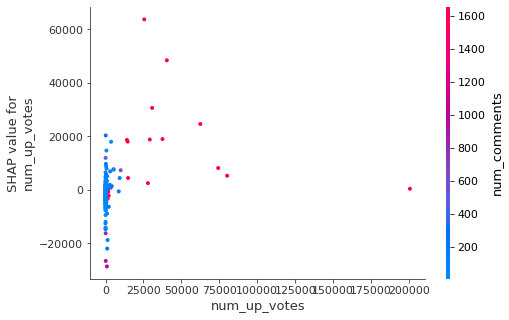

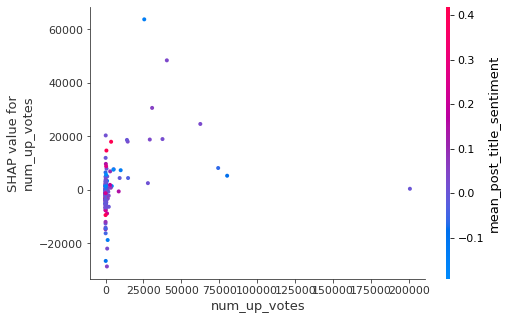

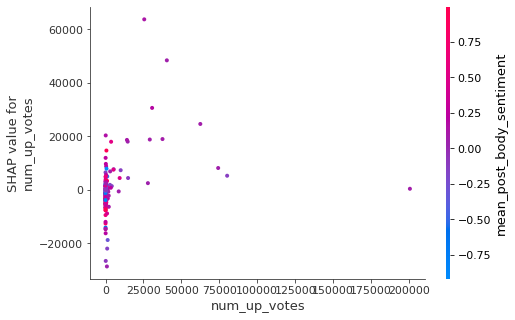

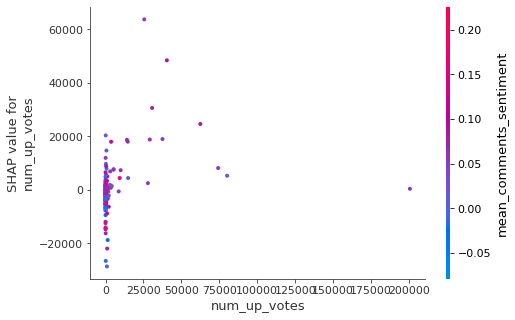

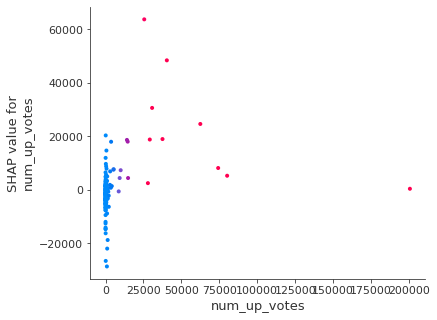

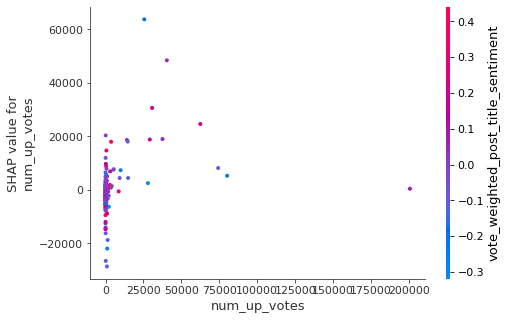

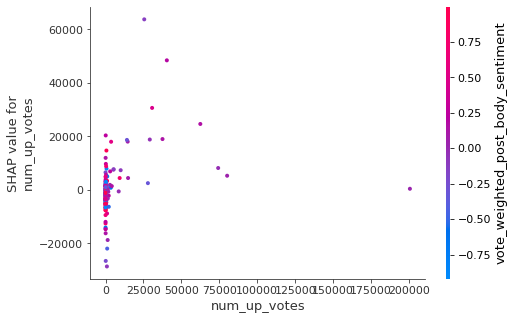

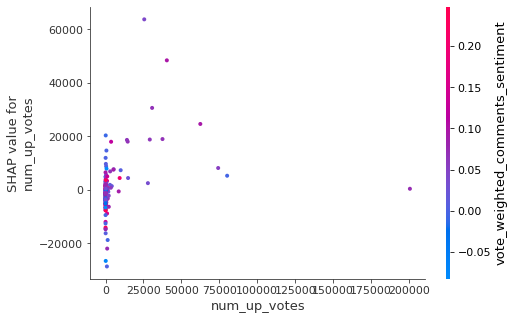

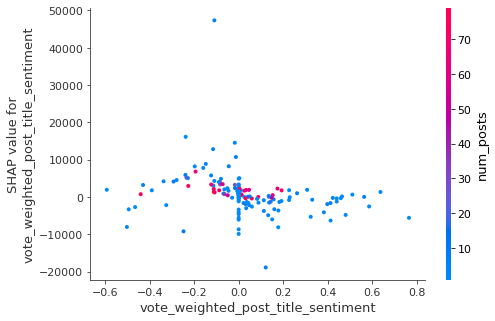

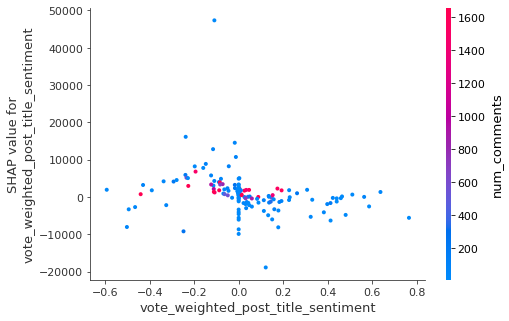

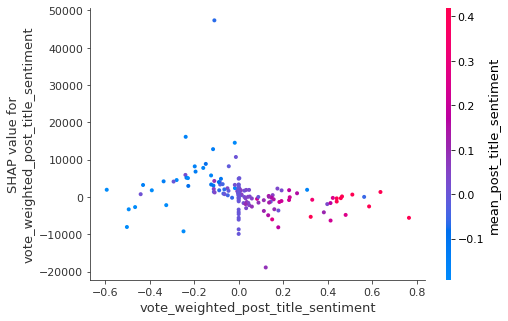

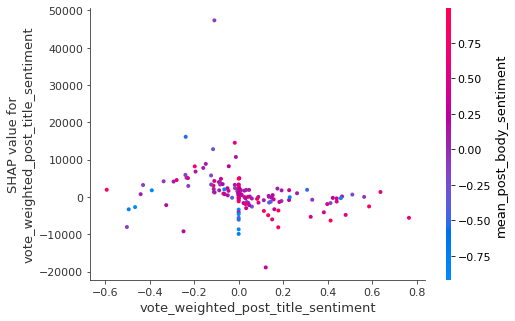

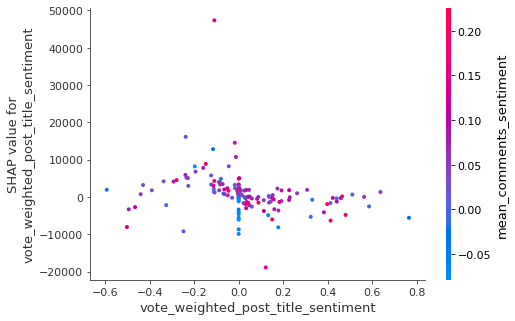

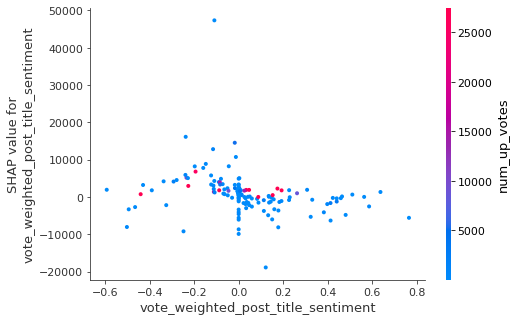

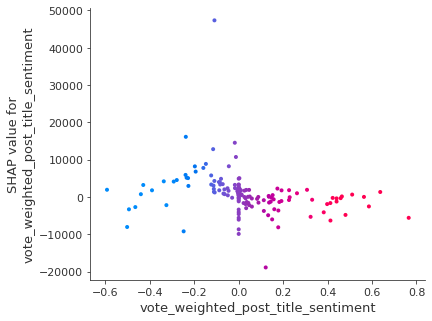

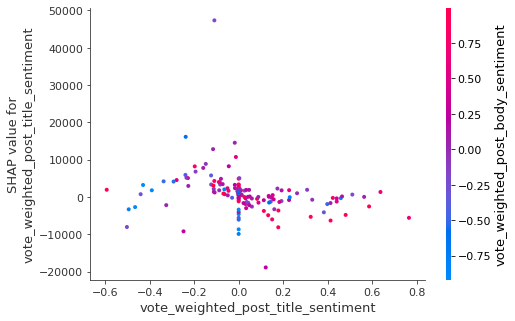

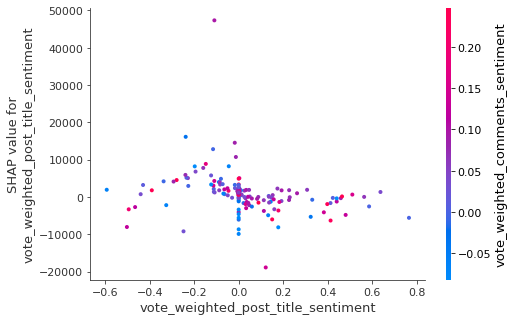

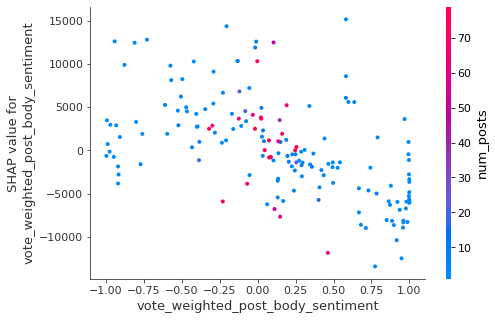

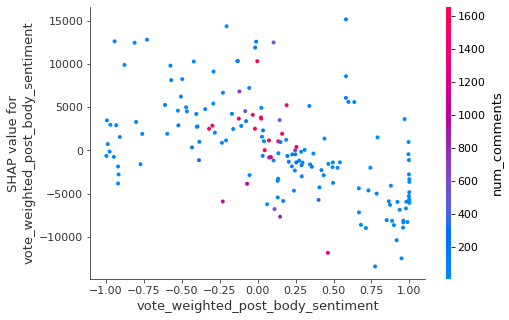

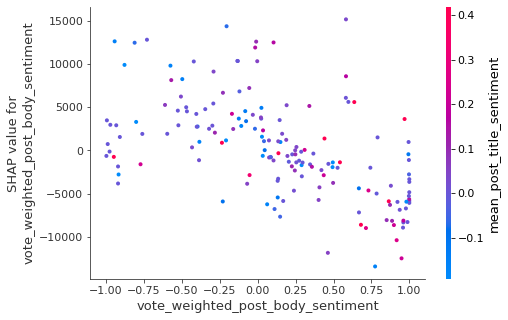

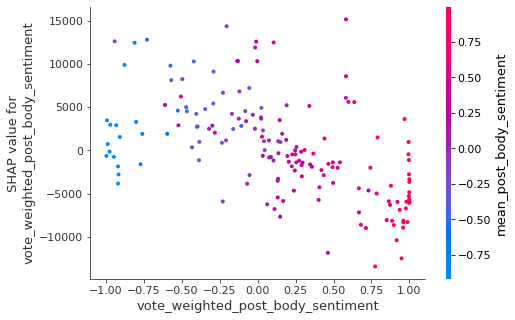

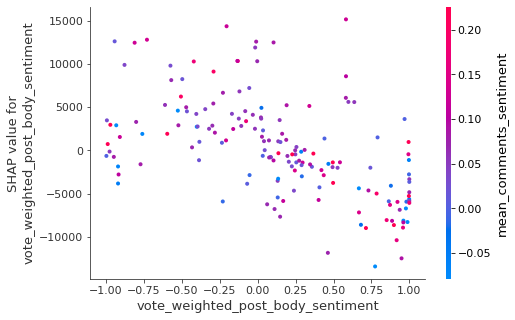

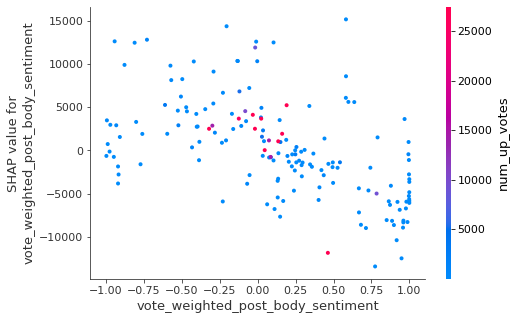

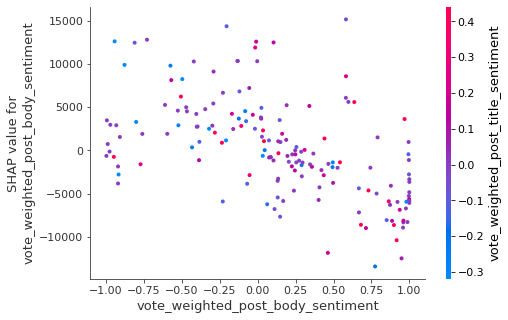

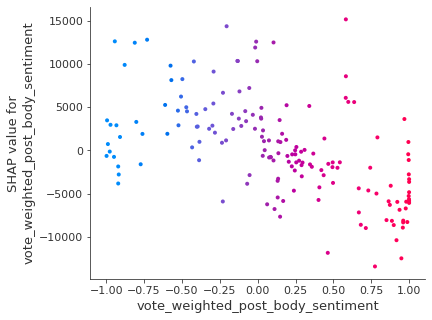

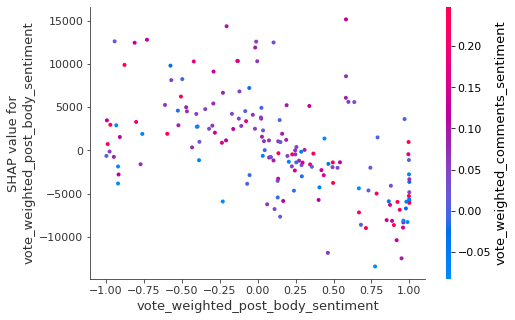

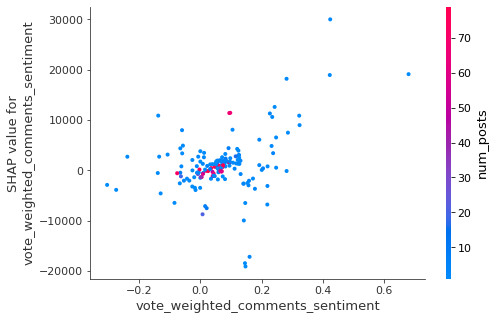

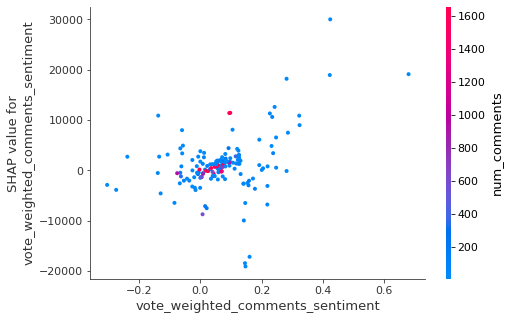

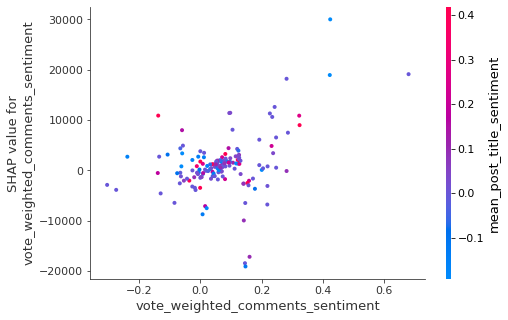

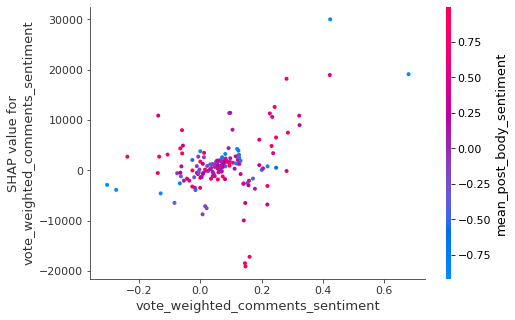

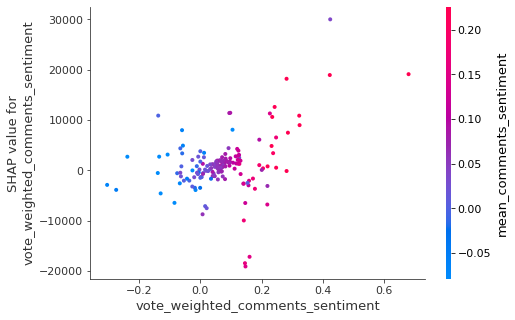

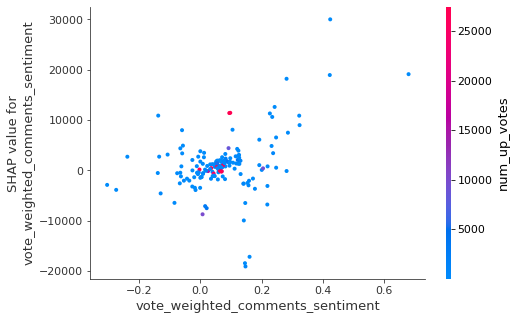

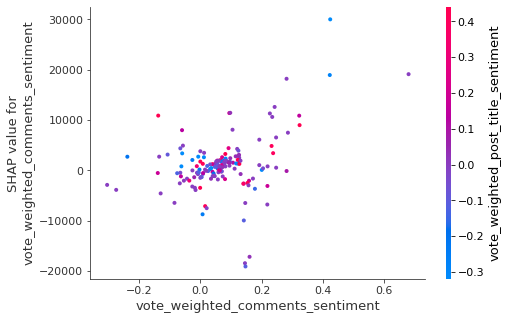

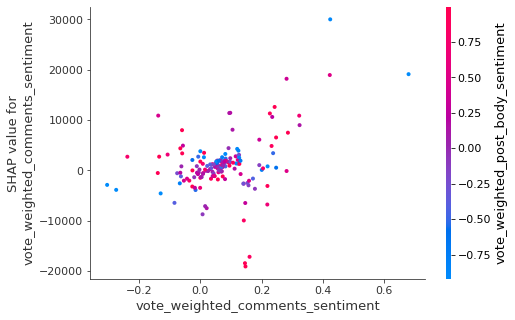

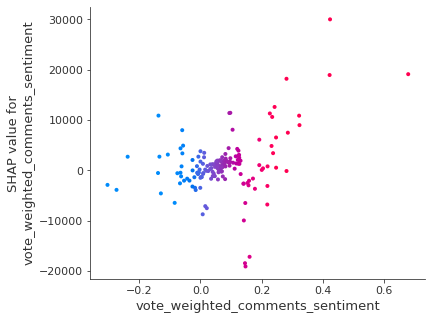

In [69]:
for x in X.columns:
    for y in X.columns:
        shap.dependence_plot(x, shap_values, Xv, interaction_index=y)